# Self-Driving Car Engineer Nanodegree
## Project: Advanced Lane Finding


In the following code camera calibration is performed. The code is based on [Udacity's](https://github.com/udacity/CarND-Camera-Calibration/blob/master/camera_calibration.ipynb) example.

## Camera calibration

In [1]:
#Load nessesery modules and set up
import cv2
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

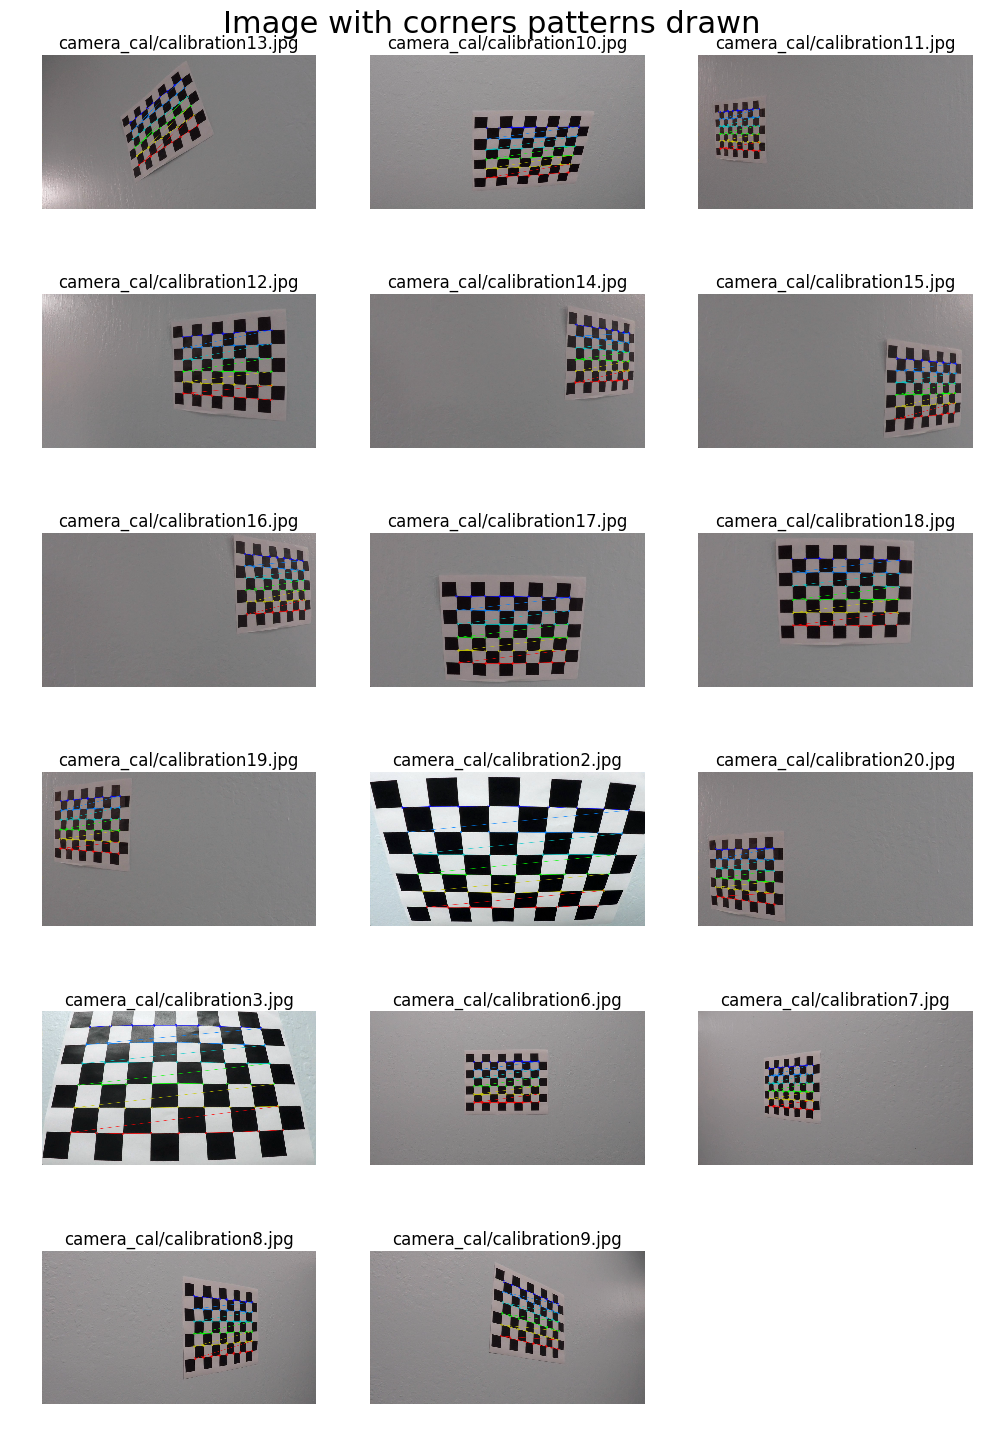

Corners were found on 17 out of 20 it is 85.0 % of calibration images


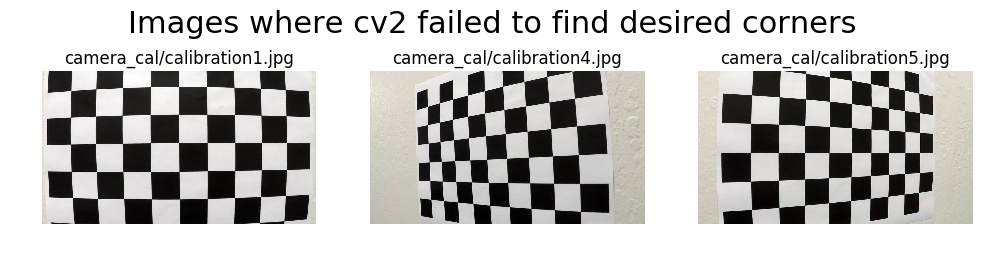

In [2]:
x_cor = 9 #Number of corners to find
y_cor = 6
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((y_cor*x_cor,3), np.float32)
objp[:,:2] = np.mgrid[0:x_cor, 0:y_cor].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob('camera_cal/calibration*.jpg') # Make a list of paths to calibration images
# Step through the list and search for chessboard corners
corners_not_found = [] #Calibration images in which opencv failed to find corners
plt.figure(figsize=(12, 18)) #Figure for calibration images
plt.figtext(0.5,0.9,'Image with corners patterns drawn', fontsize=22, ha='center')
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (x_cor,y_cor), None) #Find the chessboard corners
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        plt.subplot(6, 3, len(imgpoints))
        cv2.drawChessboardCorners(img, (x_cor,y_cor), corners, ret)
        plt.imshow(img)
        plt.title(fname)
        plt.axis('off')
        #write_name = 'readme_img/corners_found_'+str(len(imgpoints))+'.jpg'
        #cv2.imwrite(write_name, img)
    else:
        corners_not_found.append(fname)
plt.show()

#I use python 2.7
print 'Corners were found on', str(len(imgpoints)), 'out of', str(len(images)), 'it is',    str(len(imgpoints)*100.0/len(images)),'% of calibration images'

plt.figure(figsize=(12, 4))
plt.figtext(.5,.8,'Images in which cv2 failed to find desired corners', fontsize=22, ha='center')
for i, p in enumerate(corners_not_found):
    plt.subplot(1, 3, i+1)
    plt.imshow(mpimg.imread(p)) #draw the first image of each class
    plt.title(p)
    plt.axis('off')
plt.show()
#plt.savefig("readme_img/no_corners.jpg")

As we can see, 85% (17 out of 20) of calibration images were succesfully recognized by `cv2.findChessboardCorners`. The rest 3 images were not processed as the algorithm failed to find required number of corners. 

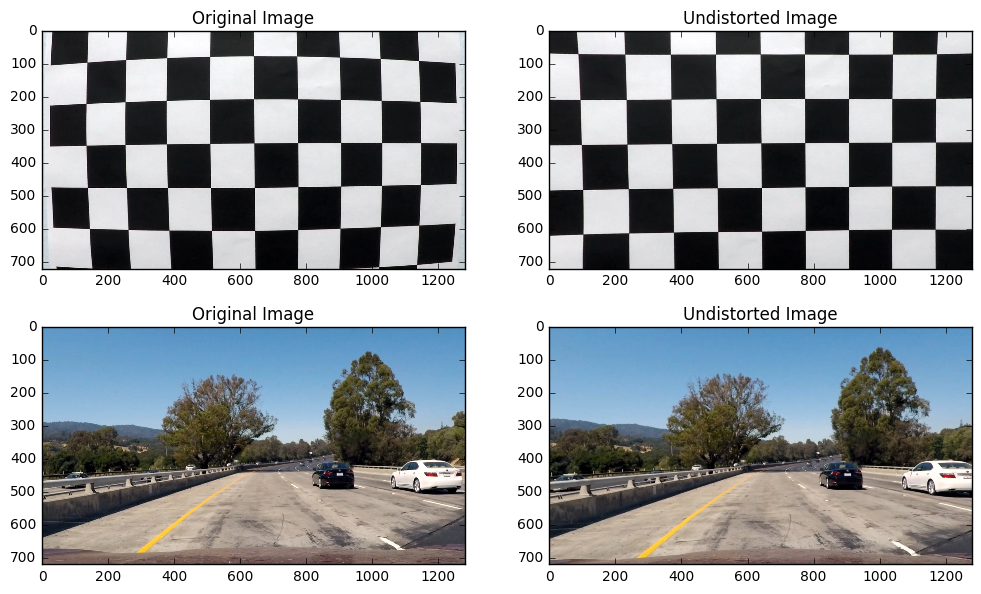

In [3]:
# Undistortion process
# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)
#cv2.imwrite('calibration_wide/test_undist.jpg',dst)

# Save the camera calibration result for later use
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open("camera_cal/calibration.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
plt.figure(figsize=(12, 7))
plt.subplot(2, 2, 1)
plt.imshow(img)
plt.title("Original Image")
plt.subplot(2, 2, 2)
plt.imshow(undistort(img))
plt.title("Undistorted Image")
img = cv2.imread('test_images/test1.jpg')
plt.subplot(2, 2, 3)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.subplot(2, 2, 4)
plt.imshow(cv2.cvtColor(undistort(img), cv2.COLOR_BGR2RGB))
plt.title("Undistorted Image")
plt.savefig("readme_img/undist_img.jpg")


## Create of thresholded binary image

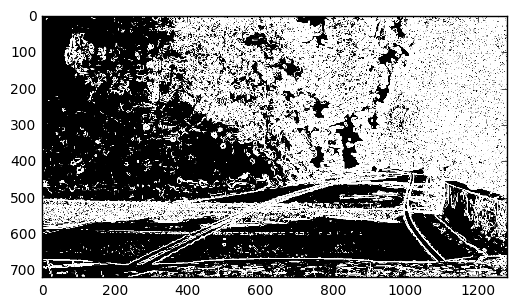

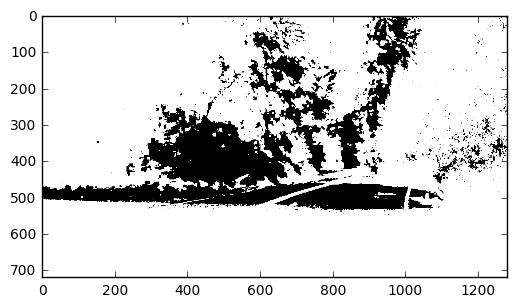

In [4]:
def eq_Hist(img):
    img[:, :, 0] = cv2.equalizeHist(img[:, :, 0])
    img[:, :, 1] = cv2.equalizeHist(img[:, :, 1])
    img[:, :, 2] = cv2.equalizeHist(img[:, :, 2])
    return img

def sobel_img(img, thresh_min = 25, thresh_max = 255, sobel_kernel = 11):
    sobelx = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    sobely = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    scaled_sobelx = np.uint16(255*sobelx/np.max(sobelx))
    scaled_sobely = np.uint16(255*sobely/np.max(sobely))
    sobel_sum = scaled_sobelx+0.2*scaled_sobely
    scaled_sobel_sum = np.uint8(255*sobel_sum/np.max(sobel_sum))
    sum_binary = np.zeros_like(scaled_sobel_sum)
    sum_binary[(scaled_sobel_sum >= thresh_min) & (scaled_sobel_sum <= thresh_max)] = 1
    return sum_binary
    
def sobel_mag_img(img, thresh_min = 25, thresh_max = 255, sobel_kernel = 11):
    sobelx = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    sobely = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scaled_gradmag = np.uint8(255*gradmag/np.max(gradmag))
    gradmag_binary = np.zeros_like(scaled_gradmag)
    gradmag_binary[(scaled_gradmag >= thresh_min) & (scaled_gradmag <= thresh_max)] = 1
    return gradmag_binary

def sobel_dir_img(img, thresh_min = 0.0, thresh_max = 1.5, sobel_kernel = 11):
    sobelx = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    sobely = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    graddir = np.arctan2(sobely, sobelx)
    graddir_binary =  np.zeros_like(graddir)
    graddir_binary[(graddir >= thresh_min) & (graddir <= thresh_max)] = 1
    return  graddir_binary

def red_thres(img, thresh_min = 25, thresh_max = 255):
    red = img[:,:,2]
    red_binary = np.zeros_like(red)
    red_binary[(red >= thresh_min) & (red <= thresh_max)]  = 1
    return red_binary
    
def s_thres(img, thresh_min = 25, thresh_max = 255):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > thresh_min) & (s_channel <= thresh_max)] = 1
    return s_binary

def s_hls(img):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    return hls[:,:,2]
    
def thres_img(img):
    img = eq_Hist(img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #We use cv2.imread
    red = red_thres(img, 50, 255)
    res = sobel_mag_img(gray, 25, 255, 5)
    res1 = sobel_dir_img(gray, 0.6, 1.3, 5)
    combined = np.zeros_like(res)
    combined[((res == 1) & (res1 == 1))] = 1
    
    res = s_thres(img, 50, 255)
    return red
    

img = cv2.imread('test_images/test_ch.jpg')
img = eq_Hist(img)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(sobel_mag_img(gray, 10, 255,5), cmap='gray')
plt.figure()
plt.imshow(red_thres(img, 50, 255), cmap='gray')


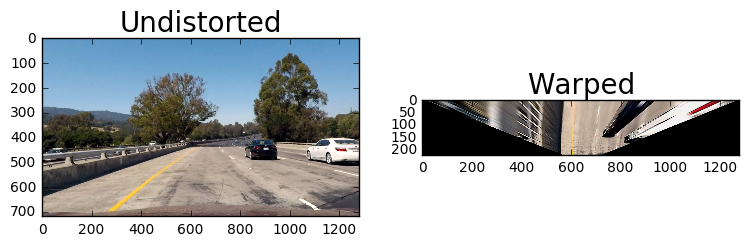

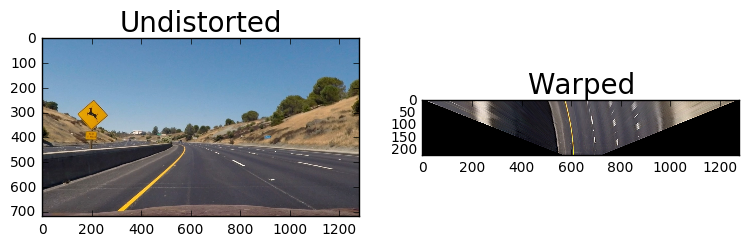

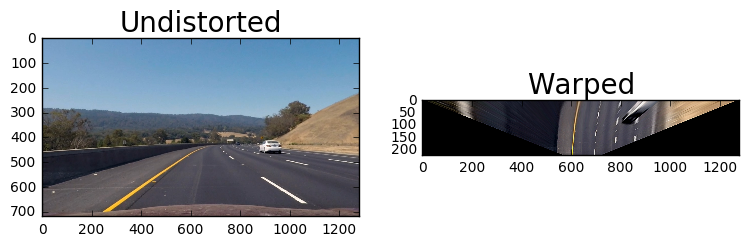

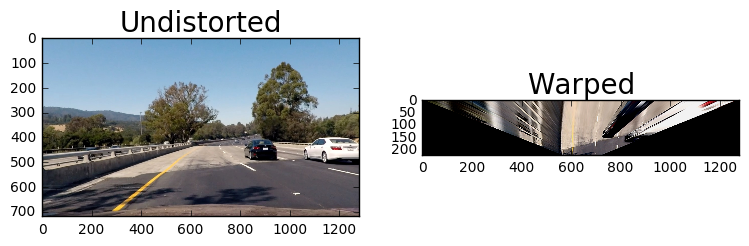

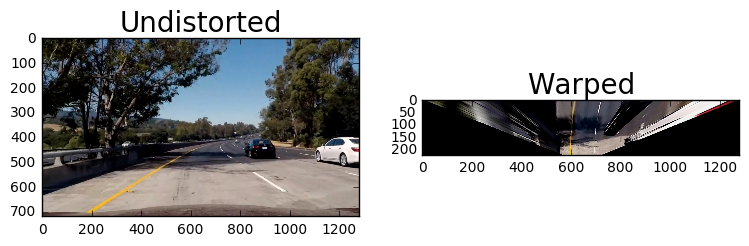

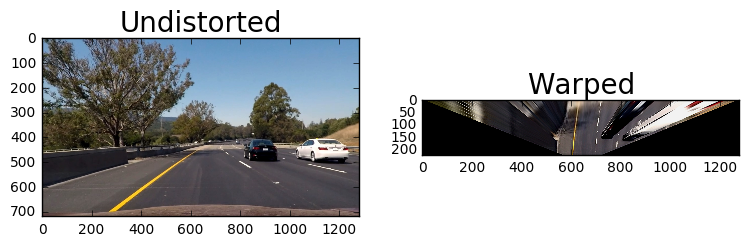

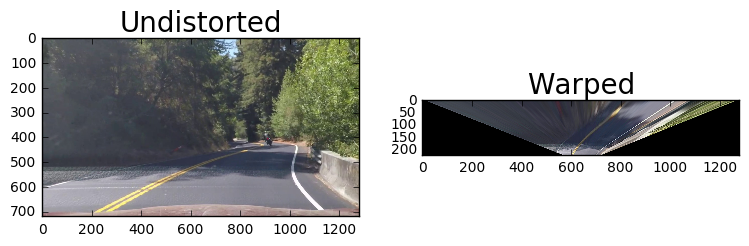

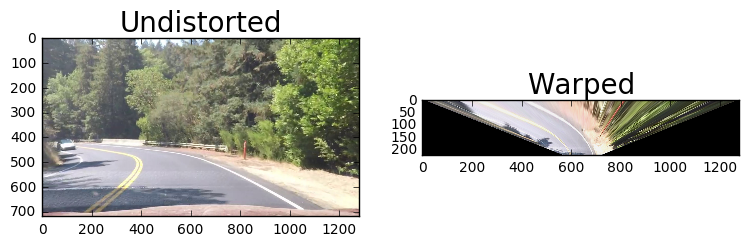

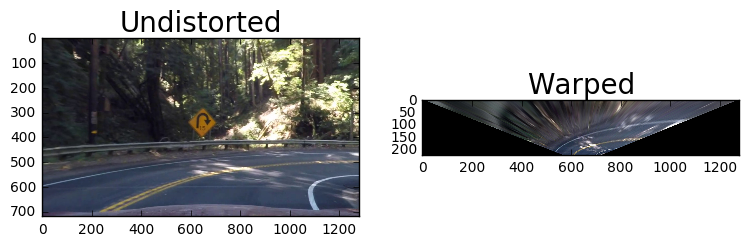

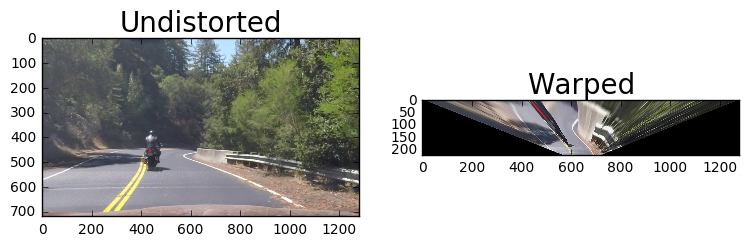

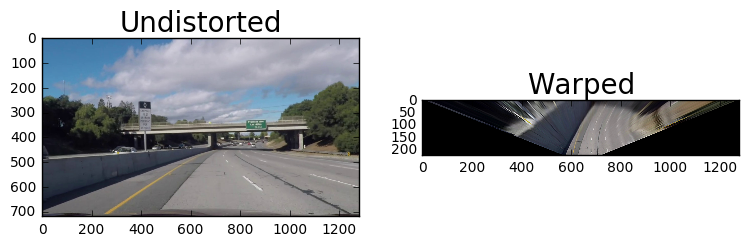

In [248]:
def sharpen_img(img):
    gb = cv2.GaussianBlur(img, (5,5), 20.0)
    return cv2.addWeighted(img, 2, gb, -1, 0)

#Compute linear image transformation img*s+m
def lin_img(img,s=1.0,m=0.0):
    img2=cv2.multiply(img, np.array([s]))
    return cv2.add(img2, np.array([m]))

#Change image contrast; s>1 - increase
def contr_img(img, s=1.0):
    m=127.0*(1.0-s)
    return lin_img(img, s, m)

def create_M():
    src = np.float32([[0, 673], [1207, 673], [0, 450], [1280, 450]])
    dst = np.float32([[569, 223], [711, 223], [0, 0], [1280, 0]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv

def transform(img, M):
    undist = undistort(img)
    img_size = (1280, 223)
    warped = cv2.warpPerspective(undist, M, img_size)
    warped = sharpen_img(warped)
    warped = contr_img(warped, 1.1)
    return warped

def show_warped(img, M):
    f, (plot1, plot2) = plt.subplots(1, 2, figsize=(9, 3))
    plot1.imshow(cv2.cvtColor(undistort(img), cv2.COLOR_BGR2RGB))
    plot1.set_title('Undistorted', fontsize=20)
    plot2.imshow(cv2.cvtColor(transform(img, M), cv2.COLOR_BGR2RGB))
    plot2.set_title('Warped', fontsize=20)

def show_img(img):
    if len(img.shape)==3:
        plt.figure()
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        plt.figure()
        plt.imshow(img, cmap='gray')

M, Minv = create_M()
for image in glob.glob('test_images/test*.jpg'):
    img=cv2.imread(image)
    show_warped(img, M)

(60, 30)
(60, 30)
(60, 30)
(60, 30)
(60, 30)
(60, 30)
(60, 30)
(60, 30)
(60, 30)
(60, 30)
(60, 30)


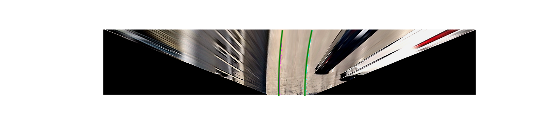

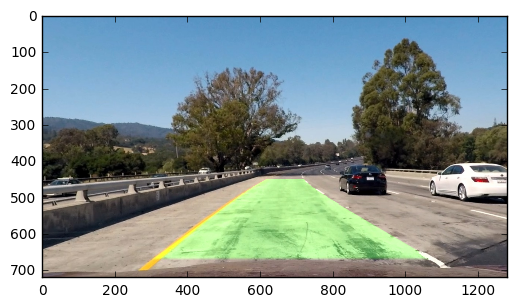

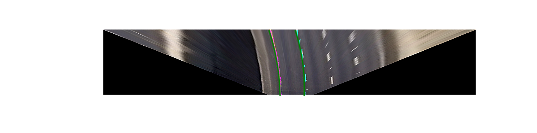

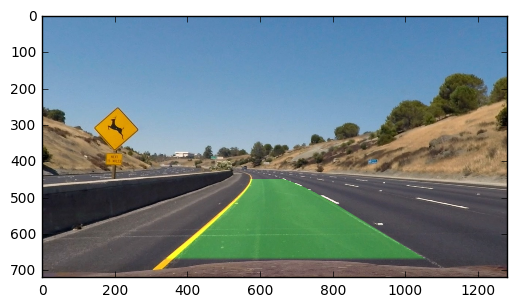

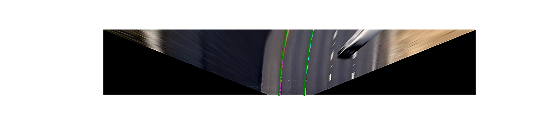

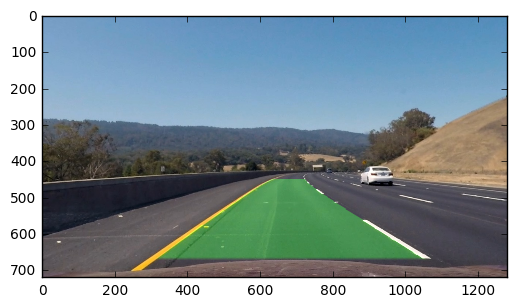

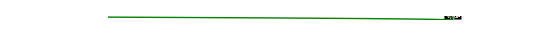

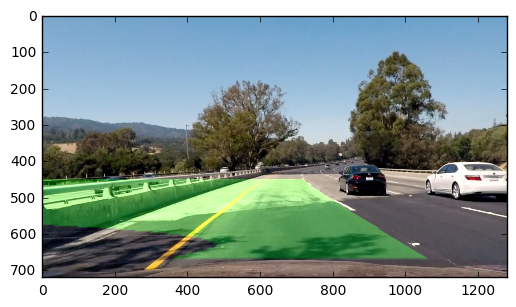

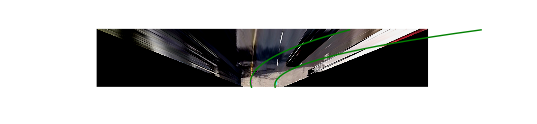

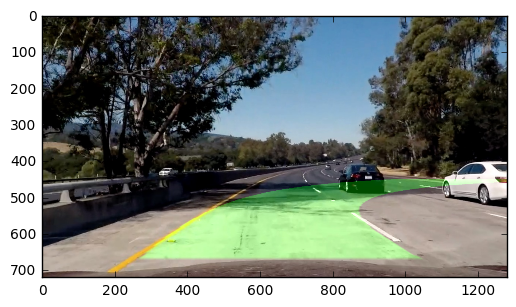

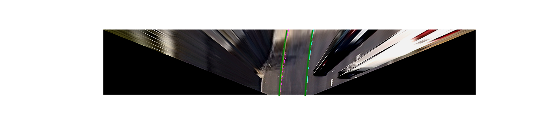

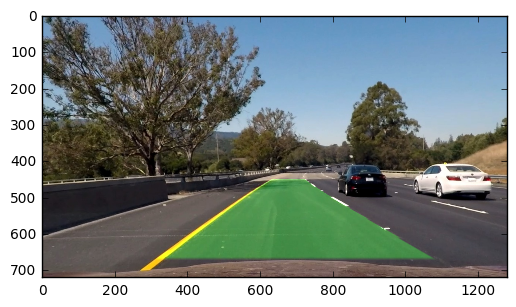

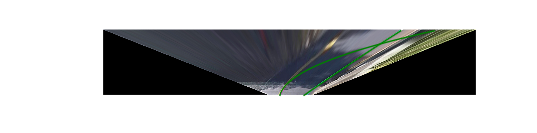

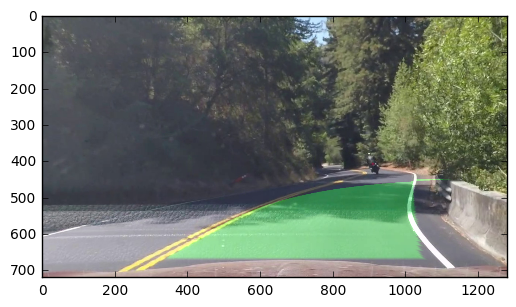

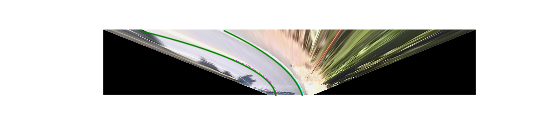

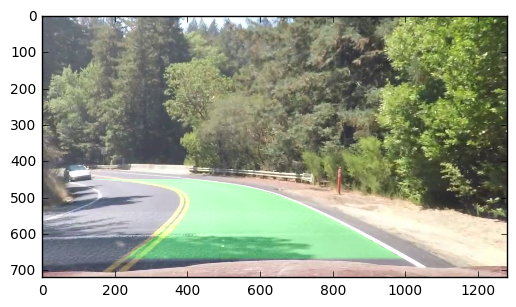

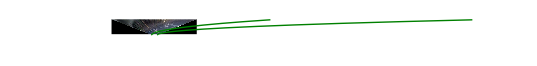

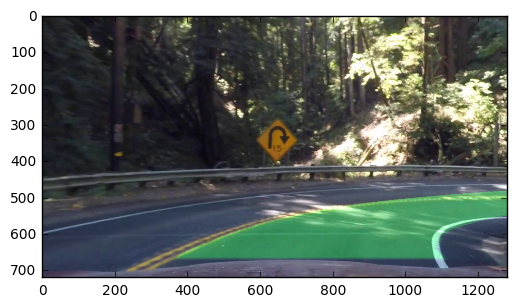

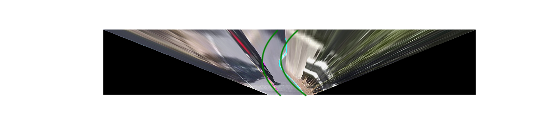

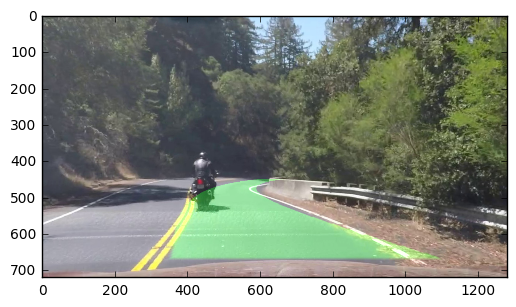

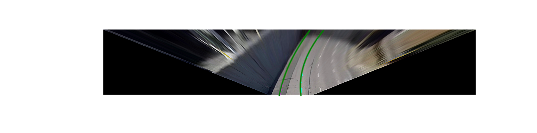

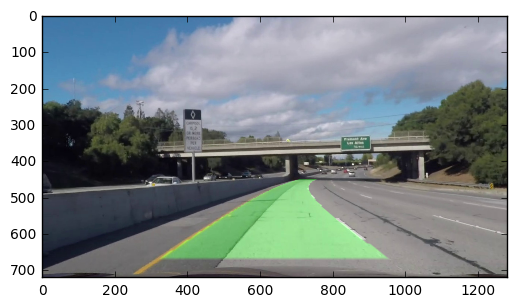

In [282]:
#create virtual sensors

WINDOW_SIZE = 20 #20
THRES_L = 50 #50
THRES_R = 50
DIV = 15 #10

def find(img, left=True, p_ord=2):
    global THRES_L, THRES_R
    x_pos = []
    y_pos = []
    coef = np.zeros(2)
    max_l = img.shape[0] #number of lines in the img
    if left:
        sens = s_hls(img[max_l-1:max_l,590:620,:])#+img[max_l-1:max_l,590:620,2]#+img[max_l-1:max_l,590:620,1]+
        x = list(reversed(sens[0,:])).index(max(sens[0,:]))
        x_pos.append(620-x)
    else:
        sens = img[max_l-1:max_l,670:700,2]
        x = list(sens[0,:]).index(max(sens[0,:]))
        x_pos.append(670+x)
    y_pos.append(max_l)
    for i in range(1, max_l):
        if len(x_pos)<11:
            cent = x_pos[-1]
        else:
            cent = x_pos[-1]#int((coef[0]*(max_l-i)+coef[1]+x_pos[-1])/2.0)
        #sens = img[max_l-1-i:max_l-i,cent-WINDOW_SIZE:cent+WINDOW_SIZE,2]+img[max_l-1-i:max_l-i,cent-WINDOW_SIZE:cent+WINDOW_SIZE,1]+s_hls(img[max_l-1-i:max_l-i,cent-WINDOW_SIZE:cent+WINDOW_SIZE,:])
        if left:
            sens = s_hls(img[max_l-1-i:max_l-i,cent-WINDOW_SIZE:cent+WINDOW_SIZE,:])
        else:
            sens = img[max_l-1-i:max_l-i,cent-WINDOW_SIZE:cent+WINDOW_SIZE,2]
        x_max = max(sens[0,:])
        if left:
            loc_thres = THRES_L
        else:
            loc_thres = THRES_R
        if int((x_max-np.mean(sens[0,:])))>loc_thres:
            if len(sens[0,:]) < WINDOW_SIZE: #If we out of the image
                break
            if left:
                x = list(reversed(sens[0,:])).index(x_max)
                x = cent+WINDOW_SIZE-x
            else:
                x = list(sens[0,:]).index(x_max)
                x = cent-WINDOW_SIZE+x
            y = max_l-i
            if x-1 < 569.0*(max_l-y)/233.0 or x+1> 569.0*(max_l-y)/233.0+711 or np.nonzero(sens[0,:])<WINDOW_SIZE: #if the sensor touchs black triangle
                break
            p = len(x_pos)
            if p > 9:
                coef = np.polyfit(np.array(y_pos[p-10:]), np.array(x_pos[p-10:]), 1)
                x_fit = coef[0]*y+coef[1]
                if abs(x-x_fit) < DIV:
                    x_pos.append(x)
                    y_pos.append(y)
            else:        
                x_pos.append(x)
                y_pos.append(y)
    coef = np.polyfit(y_pos, x_pos, 2)
    ploty = np.array(y_pos)
    fit = coef[0]*ploty**2 + coef[1]*ploty + coef[2]
    diff = abs(x_pos-fit)
    while(max(diff) > DIV):
        i = np.argmax(diff)
        x_pos.pop(i)
        y_pos.pop(i)
        ploty = np.array(y_pos)
        coef = np.polyfit(y_pos, x_pos, 2)
        fit = coef[0]*ploty**2 + coef[1]*ploty + coef[2]
        diff = abs(x_pos-fit)
    #print(len(x_pos))
    #if len(x_pos) < 30:
        #if left:
            #if THRES_L > 15:
                #THRES_L -= 5
                #find(img, left, p_ord)
        #else:
            #if THRES_R > 15:
                #THRES_R -= 5
                #find(img, left, p_ord)
    #else:
        #if left:
            #THRES_L += 5
        #else:
            #THRES_R += 5
    return np.polyfit(y_pos, x_pos, p_ord), x_pos, y_pos


def draw_lane_img_p(img_path):
    return cv2.imread(img_path)

    
def get_lane(img, plot=False):
    warp = transform(img, M)
    img = undistort(img)
    ploty = np.linspace(0, warp.shape[0]-1, num=warp.shape[0])
    left_fit, x2, y2 = find(warp)
    l_pol = np.poly1d(left_fit)
    left_fitx = l_pol(ploty)
    right_fit, x, y = find(warp, False)
    r_pol = np.poly1d(right_fit)
    right_fitx = r_pol(ploty)
    if plot:
        for i in range(len(x)):
            cv2.circle(warp, (x[i], y[i]), 1, (255,255,50))
        for i in range(len(x2)):
            cv2.circle(warp, (x2[i], y2[i]), 1, (255,50,250))   
        show_img(warp)
        plt.axis('off')
        plt.plot(left_fitx, ploty, color='green', linewidth=1)
        plt.plot(right_fitx, ploty, color='green', linewidth=1)
        cv2.imwrite('img.jpg', warp)
    return img,  left_fitx, right_fitx, ploty

right_fit_p = np.zeros(3)
left_fit_p = np.zeros(3)
lane_w_p = 90


def get_lane_video(img):
    global right_fit_p, left_fit_p, lane_w_p
    warp = transform(img, M)
    img = undistort(img)
    ploty = np.linspace(0, warp.shape[0]-1, num=warp.shape[0])
    right_fit, x, y = find(warp, False)
    left_fit, x2, y2 = find(warp)
    l_pol = np.poly1d(left_fit)
    left_fitx = l_pol(ploty)
    r_pol = np.poly1d(right_fit)
    right_fitx = r_pol(ploty)
    d_fit = right_fitx-left_fitx
    lane_w = np.mean(d_fit)
    if max(abs(d_fit-lane_w)) > DIV*2: #Measure non parallelity
        #print("nonpar", left_fit[2], left_fit_p[2])
        #if abs(left_fit[2]-left_fit_p[2])>DIV:   
        left_fit = left_fit_p
        #else:
            #left_fit = left_fit_p*(1.0-len(x2)/446.0)+left_fit*(len(x2)/446.0)
            #left_fit_p = left_fit
        #if abs(right_fit[2]-right_fit_p[2])>DIV:
        
        #if THRES_R>50:
            #right_fit = right_fit_p*(1.0-len(x)/223.0)+right_fit*(len(x)/223.0)
            #right_fit_p = right_fit
            #print("R only")
        #else:
        right_fit = right_fit_p
        #else:
            #right_fit = right_fit_p*(1.0-len(x)/446.0)+right_fit*(len(x)/446.0)
            #left_fit = right_fit
            #left_fit[2] = left_fit[2]-90
            #right_fit_p = right_fit
            #left_fit_p = left_fit
            #print("right_to_left")
        print("d_fit", max(abs(d_fit-lane_w)))
    else:
        if right_fit_p[2]==0: #the first video frame
            right_fit_p = right_fit
            left_fit_p = left_fit
            lane_w_p = lane_w
        else: #Apply low-pass filter
            if abs(lane_w_p - lane_w) < DIV and lane_w < 110:
                print("par", left_fit[0], left_fit_p[0])
                left_fit = left_fit_p*(1.0-len(x2)/223.0)+left_fit*(len(x2)/223.0)
                right_fit = right_fit_p*(1.0-len(x)/223.0)+right_fit*(len(x)/223.0)
                right_fit_p = right_fit
                left_fit_p = left_fit
                lane_w_p = lane_w
            else:
                print("lane_w", abs(lane_w_p - lane_w), lane_w)
                left_fit = left_fit_p
                right_fit = right_fit_p
                lane_w_p = lane_w
                
    l_pol = np.poly1d(left_fit)
    left_fitx = l_pol(ploty)
    r_pol = np.poly1d(right_fit)
    right_fitx = r_pol(ploty)
    return img,  left_fitx, right_fitx, ploty
    
def draw_lane(img, video=False):
    if video:
        img, left_fitx, right_fitx, ploty = get_lane_video(img)
    else:
        global THRES_L, THRES_R
        THRES_L = 60 #50
        THRES_R = 30
        img, left_fitx, right_fitx, ploty = get_lane(img, True)
    warp_zero = np.zeros((233,1280)).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    print(THRES_L, THRES_R)
    if video:
        return(result)
    else:
        show_img(result)
    
#Test on images from the 'test_images' directory
for image in glob.glob('test_images/test*.jpg'):
    draw_lane(draw_lane_img_p(image))

In [284]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_image(image):
    return draw_lane(image, True)
THRES_L = 60
THRES_R = 30
#Process video
output = 'project_video_proc.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(process_image)
%time clip.write_videofile(output, audio=False)

('lane_w', 28.15908419938431, 83.946695335092713)
(60, 30)
[MoviePy] >>>> Building video project_video_proc.mp4
[MoviePy] Writing video project_video_proc.mp4


  0%|          | 2/1261 [00:00<03:22,  6.21it/s]

('par', -0.00065773370310433016, -0.00036144611419687491)
(60, 30)
('par', -0.00061446979806258799, -0.00065773370310433016)
(60, 30)


  0%|          | 4/1261 [00:00<03:21,  6.23it/s]

('par', -0.00061033358646129284, -0.00061446979806258799)
(60, 30)
('par', -0.0005994036856606966, -0.00061033358646129284)
(60, 30)


  0%|          | 6/1261 [00:00<03:18,  6.31it/s]

('par', -0.00060496020005385009, -0.0005994036856606966)
(60, 30)
('par', -0.00051861584438738894, -0.00060496020005385009)
(60, 30)


  1%|          | 8/1261 [00:01<03:19,  6.28it/s]

('par', -0.0004894635664881153, -0.00051861584438738894)
(60, 30)
('par', -0.00054373767444199149, -0.0004894635664881153)
(60, 30)


  1%|          | 10/1261 [00:01<03:18,  6.30it/s]

('par', -0.00053424374513797097, -0.00054373767444199149)
(60, 30)
('par', -0.00053154219930798892, -0.00053424374513797097)
(60, 30)


  1%|          | 12/1261 [00:01<03:16,  6.35it/s]

('par', -0.00051846797098710864, -0.00053154219930798892)
(60, 30)
('par', -0.00044932393587099139, -0.00051846797098710864)
(60, 30)


  1%|          | 14/1261 [00:02<03:14,  6.40it/s]

('par', -0.00047568881649598431, -0.00044932393587099139)
(60, 30)
('par', -0.00049275268874317756, -0.00047568881649598431)
(60, 30)


  1%|▏         | 16/1261 [00:02<03:16,  6.34it/s]

('par', -0.0005385353380605324, -0.00049275268874317756)
(60, 30)
('par', -0.00054415093652764068, -0.0005385353380605324)
(60, 30)


  1%|▏         | 18/1261 [00:02<03:16,  6.34it/s]

('par', -0.00056219867285544646, -0.00054415093652764068)
(60, 30)
('par', -0.00063168382872948886, -0.00056219867285544646)
(60, 30)


  2%|▏         | 20/1261 [00:03<03:18,  6.25it/s]

('par', -0.00057769110459689893, -0.00063168382872948886)
(60, 30)
('par', -0.00052308762741364219, -0.00057769110459689893)
(60, 30)


  2%|▏         | 22/1261 [00:03<03:16,  6.30it/s]

('par', -0.00046514541041051285, -0.00052308762741364219)
(60, 30)
('par', -0.00048745470797695848, -0.00046514541041051285)
(60, 30)


  2%|▏         | 24/1261 [00:03<03:18,  6.24it/s]

('par', -0.00048595834668111994, -0.00048745470797695848)
(60, 30)
('par', -0.00054174154675341282, -0.00048595834668111994)
(60, 30)


  2%|▏         | 26/1261 [00:04<03:16,  6.28it/s]

('par', -0.00061038875335891237, -0.00054174154675341282)
(60, 30)
('par', -0.00060035392731249847, -0.00061038875335891237)
(60, 30)


  2%|▏         | 28/1261 [00:04<03:09,  6.52it/s]

('par', -0.00058003553453298148, -0.00060035392731249847)
(60, 30)
('par', -0.00057781808639106012, -0.00058003553453298148)
(60, 30)


  2%|▏         | 30/1261 [00:04<03:07,  6.55it/s]

('par', -0.00068639731327676872, -0.00057781808639106012)
(60, 30)
('par', -0.00072709057145875489, -0.00068639731327676872)
(60, 30)


  3%|▎         | 32/1261 [00:05<03:12,  6.40it/s]

('par', -0.00080277792293092999, -0.00072709057145875489)
(60, 30)
('par', -0.00084250788220716121, -0.00080277792293092999)
(60, 30)


  3%|▎         | 34/1261 [00:05<03:13,  6.34it/s]

('par', -0.00080904507836715911, -0.00084250788220716121)
(60, 30)
('par', -0.0007541840468508655, -0.00080904507836715911)
(60, 30)


  3%|▎         | 36/1261 [00:05<03:12,  6.35it/s]

('par', -0.00077566714667740228, -0.0007541840468508655)
(60, 30)
('par', -0.00075826737657391167, -0.00077566714667740228)
(60, 30)


  3%|▎         | 38/1261 [00:06<03:13,  6.32it/s]

('par', -0.00077976451294835692, -0.00075826737657391167)
(60, 30)
('par', -0.00088194307397683155, -0.00077976451294835692)
(60, 30)


  3%|▎         | 40/1261 [00:06<03:15,  6.25it/s]

('par', -0.00089716358840604608, -0.00088194307397683155)
(60, 30)
('par', -0.00090973641817753326, -0.00089716358840604608)
(60, 30)


  3%|▎         | 42/1261 [00:06<03:15,  6.23it/s]

('par', -0.00086478551593299324, -0.00090973641817753326)
(60, 30)
('par', -0.00082421140519265725, -0.00086478551593299324)
(60, 30)


  3%|▎         | 44/1261 [00:06<03:19,  6.10it/s]

('par', -0.00075326971264717368, -0.00082421140519265725)
(60, 30)
('par', -0.0006887910343463294, -0.00075326971264717368)
(60, 30)


  4%|▎         | 46/1261 [00:07<03:19,  6.09it/s]

('par', -0.00063789647013063765, -0.0006887910343463294)
(60, 30)
('par', -0.0006733478937382526, -0.00063789647013063765)
(60, 30)


  4%|▍         | 48/1261 [00:07<03:16,  6.17it/s]

('par', -0.00066706898677357902, -0.0006733478937382526)
(60, 30)
('par', -0.00062308399488564725, -0.00066706898677357902)
(60, 30)


  4%|▍         | 50/1261 [00:07<03:21,  6.02it/s]

('par', -0.00054363321641088722, -0.00062308399488564725)
(60, 30)
('par', -0.00054451915108731934, -0.00054363321641088722)
(60, 30)


  4%|▍         | 52/1261 [00:08<03:24,  5.91it/s]

('par', -0.00052608361431891919, -0.00054451915108731934)
(60, 30)
('par', -0.00050793631643009942, -0.00052608361431891919)
(60, 30)


  4%|▍         | 54/1261 [00:08<03:27,  5.82it/s]

('par', -0.00049416156643798063, -0.00050793631643009942)
(60, 30)
('par', -0.00051812391234706432, -0.00049416156643798063)
(60, 30)


  4%|▍         | 56/1261 [00:09<03:32,  5.68it/s]

('par', -0.00047094968619634667, -0.00051812391234706432)
(60, 30)
('par', -0.00048481420480892017, -0.00047094968619634667)
(60, 30)


  5%|▍         | 58/1261 [00:09<03:28,  5.77it/s]

('par', -0.00049352926891833154, -0.00048481420480892017)
(60, 30)
('par', -0.00049598762339468378, -0.00049352926891833154)
(60, 30)


  5%|▍         | 60/1261 [00:09<03:24,  5.87it/s]

('par', -0.00050434067513996513, -0.00049598762339468378)
(60, 30)
('par', -0.00051620580175052485, -0.00050434067513996513)
(60, 30)


  5%|▍         | 62/1261 [00:10<03:25,  5.84it/s]

('par', -0.00051975182547594101, -0.00051620580175052485)
(60, 30)
('par', -0.00053697009975042949, -0.00051975182547594101)
(60, 30)


  5%|▌         | 64/1261 [00:10<03:26,  5.81it/s]

('par', -0.00053184447473556126, -0.00053697009975042949)
(60, 30)
('par', -0.00054237939360594325, -0.00053184447473556126)
(60, 30)


  5%|▌         | 66/1261 [00:10<03:26,  5.78it/s]

('par', -0.00053046073225448812, -0.00054237939360594325)
(60, 30)
('par', -0.00053636587532660842, -0.00053046073225448812)
(60, 30)


  5%|▌         | 68/1261 [00:11<03:25,  5.81it/s]

('par', -0.00054305771794563979, -0.00053636587532660842)
(60, 30)
('par', -0.00051829659452981905, -0.00054305771794563979)
(60, 30)


  6%|▌         | 70/1261 [00:11<03:21,  5.91it/s]

('par', -0.0005639414898185826, -0.00051829659452981905)
(60, 30)
('par', -0.00051077985989617233, -0.0005639414898185826)
(60, 30)


  6%|▌         | 72/1261 [00:11<03:24,  5.81it/s]

('par', -0.00051909276058580514, -0.00051077985989617233)
(60, 30)
('par', -0.00053681080125289799, -0.00051909276058580514)
(60, 30)


  6%|▌         | 74/1261 [00:12<03:27,  5.73it/s]

('par', -0.00050044308485354991, -0.00053681080125289799)
(60, 30)
('par', -0.00049920591004740567, -0.00050044308485354991)
(60, 30)


  6%|▌         | 76/1261 [00:12<03:23,  5.81it/s]

('par', -0.00045219751102103847, -0.00049920591004740567)
(60, 30)
('par', -0.00046196858053888676, -0.00045219751102103847)
(60, 30)


  6%|▌         | 78/1261 [00:12<03:20,  5.89it/s]

('par', -0.00038155156527623933, -0.00046196858053888676)
(60, 30)
('par', -0.00035131520887264373, -0.00038155156527623933)
(60, 30)


  6%|▋         | 80/1261 [00:13<03:23,  5.82it/s]

('par', -0.00035063002947465649, -0.00035131520887264373)
(60, 30)
('par', -0.00037140248825821555, -0.00035063002947465649)
(60, 30)


  7%|▋         | 82/1261 [00:13<03:21,  5.85it/s]

('par', -0.00041908627374200871, -0.00037140248825821555)
(60, 30)
('par', -0.00042959964814357409, -0.00041908627374200871)
(60, 30)


  7%|▋         | 84/1261 [00:13<03:18,  5.94it/s]

('par', -0.00043060832100661985, -0.00042959964814357409)
(60, 30)
('par', -0.00039524568672556337, -0.00043060832100661985)
(60, 30)


  7%|▋         | 86/1261 [00:14<03:19,  5.89it/s]

('par', -0.00042514940958626214, -0.00039524568672556337)
(60, 30)
('par', -0.00044585037990472445, -0.00042514940958626214)
(60, 30)


  7%|▋         | 88/1261 [00:14<03:21,  5.83it/s]

('par', -0.00048812878870909191, -0.00044585037990472445)
(60, 30)
('par', -0.00056233087755109862, -0.00048812878870909191)
(60, 30)


  7%|▋         | 90/1261 [00:14<03:23,  5.76it/s]

('par', -0.00061100440287984413, -0.00056233087755109862)
(60, 30)
('par', -0.00064443423715388447, -0.00061100440287984413)
(60, 30)


  7%|▋         | 91/1261 [00:15<03:20,  5.84it/s]

('par', -0.00063916857309101439, -0.00064443423715388447)
(60, 30)
('par', -0.00063318900367167487, -0.00063916857309101439)
(60, 30)


  7%|▋         | 94/1261 [00:15<03:19,  5.84it/s]

('par', -0.00066867568186480917, -0.00063318900367167487)
(60, 30)
('par', -0.00065447428610188149, -0.00066867568186480917)
(60, 30)


  8%|▊         | 96/1261 [00:15<03:19,  5.84it/s]

('par', -0.0006146672890276221, -0.00065447428610188149)
(60, 30)
('par', -0.00059766511230502112, -0.0006146672890276221)
(60, 30)


  8%|▊         | 97/1261 [00:16<03:24,  5.70it/s]

('par', -0.00064729247003059349, -0.00059766511230502112)
(60, 30)
('par', -0.00061176792580113198, -0.00064729247003059349)
(60, 30)


  8%|▊         | 100/1261 [00:16<03:26,  5.61it/s]

('par', -0.00065788157650463496, -0.00061176792580113198)
(60, 30)
('par', -0.00064460300216039523, -0.00065788157650463496)
(60, 30)


  8%|▊         | 102/1261 [00:17<03:31,  5.49it/s]

('par', -0.00063585562134760916, -0.00064460300216039523)
(60, 30)
('par', -0.00063729257213828621, -0.00063585562134760916)
(60, 30)


  8%|▊         | 103/1261 [00:17<03:33,  5.42it/s]

('par', -0.00064958140663764271, -0.00063729257213828621)
(60, 30)
('par', -0.00066493967509528471, -0.00064958140663764271)


  8%|▊         | 105/1261 [00:17<03:31,  5.46it/s]

(60, 30)
('par', -0.00066290209062566359, -0.00066493967509528471)
(60, 30)


  8%|▊         | 106/1261 [00:17<03:23,  5.67it/s]

('par', -0.00066618631641053312, -0.00066290209062566359)
(60, 30)
('par', -0.00064529373089118364, -0.00066618631641053312)


  9%|▊         | 108/1261 [00:18<03:31,  5.44it/s]

(60, 30)
('par', -0.00072394442613382486, -0.00064529373089118364)
(60, 30)


  9%|▊         | 110/1261 [00:18<03:21,  5.72it/s]

('par', -0.00071631964272428957, -0.00072394442613382486)
(60, 30)
('par', -0.00072978754724994357, -0.00071631964272428957)
(60, 30)


  9%|▉         | 112/1261 [00:18<03:20,  5.74it/s]

('par', -0.00075199891541231217, -0.00072978754724994357)
(60, 30)
('par', -0.00067488081534507454, -0.00075199891541231217)
(60, 30)


  9%|▉         | 113/1261 [00:18<03:20,  5.72it/s]

('par', -0.00068790052963094584, -0.00067488081534507454)
(60, 30)
('par', -0.00068465743419578856, -0.00068790052963094584)
(60, 30)


  9%|▉         | 115/1261 [00:19<03:26,  5.55it/s]

('par', -0.0007651377771399283, -0.00068465743419578856)
(60, 30)
('par', -0.00075521948708451271, -0.0007651377771399283)


  9%|▉         | 117/1261 [00:19<03:27,  5.50it/s]

(60, 30)
('par', -0.00077789210274043983, -0.00075521948708451271)
(60, 30)


  9%|▉         | 119/1261 [00:20<03:21,  5.67it/s]

('par', -0.00078471386503558345, -0.00077789210274043983)
(60, 30)
('par', -0.00077062672024426793, -0.00078471386503558345)
(60, 30)


 10%|▉         | 121/1261 [00:20<03:19,  5.72it/s]

('par', -0.00071472469916158195, -0.00077062672024426793)
(60, 30)
('par', -0.00075085640569679424, -0.00071472469916158195)
(60, 30)


 10%|▉         | 123/1261 [00:20<03:19,  5.71it/s]

('par', -0.00072555275338180374, -0.00075085640569679424)
(60, 30)
('par', -0.00079560035046715046, -0.00072555275338180374)
(60, 30)


 10%|▉         | 125/1261 [00:21<03:15,  5.82it/s]

('par', -0.00082637499216237391, -0.00079560035046715046)
(60, 30)
('par', -0.00079567967328459147, -0.00082637499216237391)
(60, 30)


 10%|▉         | 126/1261 [00:21<03:16,  5.77it/s]

('par', -0.00078304514798841309, -0.00079567967328459147)
(60, 30)
('par', -0.00074031136745462641, -0.00078304514798841309)


 10%|█         | 128/1261 [00:21<03:21,  5.62it/s]

(60, 30)
('par', -0.0007024988659123006, -0.00074031136745462641)
(60, 30)


 10%|█         | 130/1261 [00:21<03:21,  5.62it/s]

('par', -0.00073315109585221053, -0.0007024988659123006)
(60, 30)
('par', -0.00066422642260150942, -0.00073315109585221053)
(60, 30)


 10%|█         | 132/1261 [00:22<03:15,  5.79it/s]

('par', -0.00063146054968795566, -0.00066422642260150942)
(60, 30)
('par', -0.00068617958356814485, -0.00063146054968795566)
(60, 30)


 11%|█         | 134/1261 [00:22<03:18,  5.69it/s]

('par', -0.00068658664345822636, -0.00068617958356814485)
(60, 30)
('par', -0.00060794117111706808, -0.00068658664345822636)
(60, 30)


 11%|█         | 136/1261 [00:23<03:19,  5.64it/s]

('par', -0.00058547420720990993, -0.00060794117111706808)
(60, 30)
('par', -0.00061854529343313279, -0.00058547420720990993)
(60, 30)


 11%|█         | 138/1261 [00:23<03:14,  5.78it/s]

('par', -0.00057235688995123726, -0.00061854529343313279)
(60, 30)
('par', -0.00059972619983171061, -0.00057235688995123726)
(60, 30)


 11%|█         | 139/1261 [00:23<03:18,  5.66it/s]

('par', -0.00054920213519525272, -0.00059972619983171061)
(60, 30)
('par', -0.00056984630645938146, -0.00054920213519525272)
(60, 30)


 11%|█▏        | 142/1261 [00:24<03:15,  5.74it/s]

('par', -0.00062112703895875502, -0.00056984630645938146)
(60, 30)
('par', -0.00051209831610783663, -0.00062112703895875502)
(60, 30)


 11%|█▏        | 143/1261 [00:24<03:13,  5.78it/s]

('par', -0.0005846313614712601, -0.00051209831610783663)
(60, 30)
('par', -0.00059811493470165599, -0.0005846313614712601)


 11%|█▏        | 145/1261 [00:24<03:23,  5.49it/s]

(60, 30)
('par', -0.00056553414836191316, -0.00059811493470165599)
(60, 30)


 12%|█▏        | 147/1261 [00:24<03:14,  5.71it/s]

('par', -0.00070203729198713442, -0.00056553414836191316)
(60, 30)
('par', -0.00069150922817505652, -0.00070203729198713442)
(60, 30)


 12%|█▏        | 149/1261 [00:25<03:14,  5.71it/s]

('par', -0.0007675050572703171, -0.00069150922817505652)
(60, 30)
('par', -0.00077583330023319992, -0.0007675050572703171)
(60, 30)


 12%|█▏        | 150/1261 [00:25<03:15,  5.68it/s]

('par', -0.00069544044089021905, -0.00077583330023319992)
(60, 30)
('par', -0.00062986462683119117, -0.00069544044089021905)


 12%|█▏        | 152/1261 [00:25<03:16,  5.65it/s]

(60, 30)
('par', -0.00058278278075165821, -0.00062986462683119117)
(60, 30)


 12%|█▏        | 154/1261 [00:26<03:13,  5.73it/s]

('par', -0.00060013195399643052, -0.00058278278075165821)
(60, 30)
('par', -0.00057514069648064684, -0.00060013195399643052)
(60, 30)


 12%|█▏        | 156/1261 [00:26<03:06,  5.93it/s]

('par', -0.00061475901623612257, -0.00057514069648064684)
(60, 30)
('par', -0.00061269890800348659, -0.00061475901623612257)
(60, 30)


 13%|█▎        | 158/1261 [00:26<03:06,  5.91it/s]

('par', -0.0006168295702719507, -0.00061269890800348659)
(60, 30)
('par', -0.00064719192917557272, -0.0006168295702719507)
(60, 30)


 13%|█▎        | 160/1261 [00:27<03:06,  5.92it/s]

('par', -0.0005872718646394154, -0.00064719192917557272)
(60, 30)
('par', -0.00062282970486611457, -0.0005872718646394154)
(60, 30)


 13%|█▎        | 162/1261 [00:27<03:09,  5.81it/s]

('par', -0.00071840912977812752, -0.00062282970486611457)
(60, 30)
('par', -0.00069513228969833476, -0.00071840912977812752)
(60, 30)


 13%|█▎        | 164/1261 [00:27<03:05,  5.91it/s]

('par', -0.00062698484948549868, -0.00069513228969833476)
(60, 30)
('par', -0.0006255665052816282, -0.00062698484948549868)
(60, 30)


 13%|█▎        | 166/1261 [00:28<03:07,  5.85it/s]

('par', -0.0006713922435367765, -0.0006255665052816282)
(60, 30)
('par', -0.00073334728109190547, -0.0006713922435367765)
(60, 30)


 13%|█▎        | 167/1261 [00:28<03:10,  5.74it/s]

('par', -0.00072999417829282709, -0.00073334728109190547)
(60, 30)
('par', -0.00066680261879421691, -0.00072999417829282709)


 13%|█▎        | 169/1261 [00:28<03:12,  5.68it/s]

(60, 30)
('par', -0.00074313565147118312, -0.00066680261879421691)
(60, 30)


 14%|█▎        | 171/1261 [00:29<03:09,  5.76it/s]

('par', -0.00057670593479092018, -0.00074313565147118312)
(60, 30)
('par', -0.000645784030774803, -0.00057670593479092018)
(60, 30)


 14%|█▎        | 173/1261 [00:29<03:04,  5.90it/s]

('par', -0.00064833607104777921, -0.000645784030774803)
(60, 30)
('par', -0.00064346800036592117, -0.00064833607104777921)
(60, 30)


 14%|█▍        | 175/1261 [00:29<03:05,  5.86it/s]

('par', -0.00075890848773992286, -0.00064346800036592117)
(60, 30)
('par', -0.00074327536408780781, -0.00075890848773992286)
(60, 30)


 14%|█▍        | 177/1261 [00:30<03:07,  5.79it/s]

('par', -0.00077417535542041716, -0.00074327536408780781)
(60, 30)
('par', -0.00070621528680093169, -0.00077417535542041716)
(60, 30)


 14%|█▍        | 179/1261 [00:30<03:11,  5.64it/s]

('par', -0.0007002125407559233, -0.00070621528680093169)
(60, 30)
('par', -0.00073729481537446835, -0.0007002125407559233)
(60, 30)


 14%|█▍        | 180/1261 [00:30<03:14,  5.56it/s]

('par', -0.00072689112190562157, -0.00073729481537446835)
(60, 30)
('par', -0.00080402717569689466, -0.00072689112190562157)
(60, 30)


 14%|█▍        | 182/1261 [00:31<03:23,  5.29it/s]

('par', -0.0007643824150022515, -0.00080402717569689466)
(60, 30)
('par', -0.00082994353965073348, -0.0007643824150022515)


 15%|█▍        | 184/1261 [00:31<03:26,  5.20it/s]

(60, 30)
('par', -0.00086619112931427445, -0.00082994353965073348)
(60, 30)


 15%|█▍        | 186/1261 [00:31<03:21,  5.34it/s]

('par', -0.00091151808047088196, -0.00086619112931427445)
(60, 30)
('par', -0.00098528470989565648, -0.00091151808047088196)
(60, 30)


 15%|█▍        | 187/1261 [00:32<03:20,  5.35it/s]

('par', -0.00096583984740141273, -0.00098528470989565648)
(60, 30)
('par', -0.00096401248471946973, -0.00096583984740141273)


 15%|█▍        | 188/1261 [00:32<03:23,  5.29it/s]

(60, 30)
('par', -0.0010105671441730706, -0.00096401248471946973)


 15%|█▍        | 189/1261 [00:32<03:25,  5.21it/s]

(60, 30)


 15%|█▌        | 190/1261 [00:32<03:36,  4.94it/s]

('par', -0.0009988495645314485, -0.0010105671441730706)
(60, 30)
('par', -0.00095886727382376268, -0.0009988495645314485)


 15%|█▌        | 192/1261 [00:33<03:28,  5.12it/s]

(60, 30)
('par', -0.00096325222611165701, -0.00095886727382376268)
(60, 30)


 15%|█▌        | 193/1261 [00:33<03:28,  5.13it/s]

('par', -0.00090846007160961693, -0.00096325222611165701)
(60, 30)
('par', -0.00092475780948484472, -0.00090846007160961693)


 15%|█▌        | 195/1261 [00:33<03:26,  5.16it/s]

(60, 30)
('par', -0.00093301358468865525, -0.00092475780948484472)
(60, 30)


 16%|█▌        | 196/1261 [00:33<03:22,  5.27it/s]

('par', -0.00087293356879218989, -0.00093301358468865525)
(60, 30)
('par', -0.00082433773412404299, -0.00087293356879218989)
(60, 30)


 16%|█▌        | 199/1261 [00:34<03:14,  5.47it/s]

('par', -0.00068101086961547209, -0.00082433773412404299)
(60, 30)
('par', -0.00053011014498745681, -0.00068101086961547209)
(60, 30)


 16%|█▌        | 201/1261 [00:34<03:11,  5.54it/s]

('par', -0.00056781068057778139, -0.00053011014498745681)
(60, 30)
('par', -0.00059511209273809278, -0.00056781068057778139)
(60, 30)


 16%|█▌        | 203/1261 [00:35<03:10,  5.55it/s]

('par', -0.00063577172849136948, -0.00059511209273809278)
(60, 30)
('par', -0.00066359086076840852, -0.00063577172849136948)
(60, 30)


 16%|█▌        | 204/1261 [00:35<03:11,  5.52it/s]

('par', -0.00069438508834445951, -0.00066359086076840852)
(60, 30)
('par', -0.0007332757926269101, -0.00069438508834445951)


 16%|█▋        | 206/1261 [00:35<03:16,  5.36it/s]

(60, 30)
('par', -0.00076026611571328141, -0.0007332757926269101)
(60, 30)


 16%|█▋        | 208/1261 [00:35<03:13,  5.43it/s]

('par', -0.00085542640277535339, -0.00076026611571328141)
(60, 30)
('par', -0.00085094417394605631, -0.00085542640277535339)
(60, 30)


 17%|█▋        | 209/1261 [00:36<03:13,  5.44it/s]

('par', -0.0007864361168238652, -0.00085094417394605631)
(60, 30)
('par', -0.0007307518254498121, -0.0007864361168238652)
(60, 30)


 17%|█▋        | 212/1261 [00:36<03:15,  5.36it/s]

('par', -0.00072281073006475252, -0.0007307518254498121)
(60, 30)
('par', -0.00075730734198160973, -0.00072281073006475252)
(60, 30)


 17%|█▋        | 213/1261 [00:36<03:14,  5.39it/s]

('par', -0.0007171729342660935, -0.00075730734198160973)
(60, 30)
('par', -0.00075284665762106442, -0.0007171729342660935)
(60, 30)


 17%|█▋        | 216/1261 [00:37<03:12,  5.43it/s]

('par', -0.00072649548711276328, -0.00075284665762106442)
(60, 30)
('par', -0.00071103733066273003, -0.00072649548711276328)
(60, 30)


 17%|█▋        | 218/1261 [00:37<03:06,  5.58it/s]

('par', -0.00069776724353351526, -0.00071103733066273003)
(60, 30)
('par', -0.00063076525091831275, -0.00069776724353351526)
(60, 30)


 17%|█▋        | 220/1261 [00:38<03:05,  5.62it/s]

('par', -0.00066492727070408052, -0.00063076525091831275)
(60, 30)
('par', -0.00063094935819808589, -0.00066492727070408052)
(60, 30)


 18%|█▊        | 222/1261 [00:38<03:07,  5.53it/s]

('par', -0.00063267618002512533, -0.00063094935819808589)
(60, 30)
('par', -0.00055172251162755417, -0.00063267618002512533)
(60, 30)


 18%|█▊        | 224/1261 [00:38<03:09,  5.47it/s]

('par', -0.00051735581938694853, -0.00055172251162755417)
(60, 30)
('par', -0.00061882471866641687, -0.00051735581938694853)
(60, 30)


 18%|█▊        | 225/1261 [00:39<03:15,  5.31it/s]

('par', -0.00058871501762558206, -0.00061882471866641687)
(60, 30)
('par', -0.00065507328762405028, -0.00058871501762558206)
(60, 30)


 18%|█▊        | 228/1261 [00:39<03:08,  5.47it/s]

('par', -0.00061301750499853733, -0.00065507328762405028)
(60, 30)
('par', -0.00059098371548908161, -0.00061301750499853733)
(60, 30)


 18%|█▊        | 229/1261 [00:39<03:09,  5.44it/s]

('par', -0.00058606994441871482, -0.00059098371548908161)
(60, 30)
('par', -0.00053564642063724994, -0.00058606994441871482)


 18%|█▊        | 231/1261 [00:40<03:10,  5.40it/s]

(60, 30)
('par', -0.00055579963915498376, -0.00053564642063724994)
(60, 30)


 18%|█▊        | 233/1261 [00:40<03:06,  5.52it/s]

('par', -0.00061784966823218959, -0.00055579963915498376)
(60, 30)
('par', -0.00062085805952859067, -0.00061784966823218959)
(60, 30)


 19%|█▊        | 234/1261 [00:40<03:05,  5.53it/s]

('par', -0.00056452482263618991, -0.00062085805952859067)
(60, 30)
('par', -0.00056244839283612908, -0.00056452482263618991)


 19%|█▊        | 236/1261 [00:41<03:06,  5.48it/s]

(60, 30)
('par', -0.00061677472980553008, -0.00056244839283612908)
(60, 30)


 19%|█▉        | 237/1261 [00:41<03:10,  5.37it/s]

('par', -0.00065191277931976328, -0.00061677472980553008)
(60, 30)
('par', -0.00070382385075077041, -0.00065191277931976328)


 19%|█▉        | 239/1261 [00:41<03:13,  5.28it/s]

(60, 30)
('par', -0.00071591650001043749, -0.00070382385075077041)
(60, 30)


 19%|█▉        | 241/1261 [00:42<03:09,  5.39it/s]

('par', -0.00068097267714784351, -0.00071591650001043749)
(60, 30)
('par', -0.00069204914562343315, -0.00068097267714784351)
(60, 30)


 19%|█▉        | 243/1261 [00:42<03:04,  5.52it/s]

('par', -0.0006276837390000251, -0.00069204914562343315)
(60, 30)
('par', -0.00067731795178380355, -0.0006276837390000251)
(60, 30)


 19%|█▉        | 245/1261 [00:42<03:05,  5.47it/s]

('par', -0.00060480612445798086, -0.00067731795178380355)
(60, 30)
('par', -0.00069055506934699964, -0.00060480612445798086)
(60, 30)


 20%|█▉        | 246/1261 [00:42<03:11,  5.29it/s]

('par', -0.0006534672453955366, -0.00069055506934699964)
(60, 30)
('par', -0.00069285608391384489, -0.0006534672453955366)


 20%|█▉        | 248/1261 [00:43<03:13,  5.23it/s]

(60, 30)
('par', -0.00072696293680204083, -0.00069285608391384489)
(60, 30)


 20%|█▉        | 249/1261 [00:43<03:11,  5.27it/s]

('par', -0.00064502638361778916, -0.00072696293680204083)
(60, 30)
('par', -0.00061764434291476232, -0.00064502638361778916)
(60, 30)


 20%|█▉        | 252/1261 [00:44<03:07,  5.37it/s]

('par', -0.000567642568433937, -0.00061764434291476232)
(60, 30)
('par', -0.00063080083193516371, -0.000567642568433937)
(60, 30)


 20%|██        | 253/1261 [00:44<03:08,  5.34it/s]

('par', -0.00062745491062559517, -0.00063080083193516371)
(60, 30)
('par', -0.00059373324672719124, -0.00062745491062559517)


 20%|██        | 255/1261 [00:44<03:07,  5.35it/s]

(60, 30)
('par', -0.00058831220134309488, -0.00059373324672719124)
(60, 30)


 20%|██        | 257/1261 [00:45<03:02,  5.50it/s]

('par', -0.00060124932849810252, -0.00058831220134309488)
(60, 30)
('par', -0.00067325812511783009, -0.00060124932849810252)
(60, 30)


 21%|██        | 259/1261 [00:45<03:04,  5.44it/s]

('par', -0.00061781343435261002, -0.00067325812511783009)
(60, 30)
('par', -0.00060693086609731137, -0.00061781343435261002)
(60, 30)


 21%|██        | 261/1261 [00:45<03:00,  5.53it/s]

('par', -0.00059158075842323705, -0.00060693086609731137)
(60, 30)
('par', -0.0005676882688225816, -0.00059158075842323705)
(60, 30)


 21%|██        | 263/1261 [00:46<03:02,  5.46it/s]

('par', -0.00055261432206838053, -0.0005676882688225816)
(60, 30)
('par', -0.00054327414192873727, -0.00055261432206838053)
(60, 30)


 21%|██        | 264/1261 [00:46<03:04,  5.40it/s]

('par', -0.0005245823565528401, -0.00054327414192873727)
(60, 30)
('par', -0.00049603822025345422, -0.0005245823565528401)


 21%|██        | 266/1261 [00:46<03:07,  5.29it/s]

(60, 30)
('par', -0.00050233181662885629, -0.00049603822025345422)
(60, 30)


 21%|██        | 267/1261 [00:46<03:03,  5.41it/s]

('par', -0.00046556454826041929, -0.00050233181662885629)
(60, 30)
('par', -0.0004832421114404685, -0.00046556454826041929)


 21%|██▏       | 268/1261 [00:47<03:05,  5.37it/s]

(60, 30)
('par', -0.00045860699052474005, -0.0004832421114404685)


 21%|██▏       | 270/1261 [00:47<03:06,  5.31it/s]

(60, 30)
('par', -0.00047122584711619, -0.00045860699052474005)
(60, 30)


 22%|██▏       | 272/1261 [00:47<03:01,  5.44it/s]

('par', -0.00043741180314640324, -0.00047122584711619)
(60, 30)
('par', -0.00043957114650866044, -0.00043741180314640324)
(60, 30)


 22%|██▏       | 274/1261 [00:48<02:57,  5.56it/s]

('par', -0.00042075890796548657, -0.00043957114650866044)
(60, 30)
('par', -0.00048204149694521859, -0.00042075890796548657)
(60, 30)


 22%|██▏       | 275/1261 [00:48<02:57,  5.54it/s]

('par', -0.00043008407226293843, -0.00048204149694521859)
(60, 30)


 22%|██▏       | 276/1261 [00:48<03:08,  5.23it/s]

('par', -0.0004149386370436206, -0.00043008407226293843)
(60, 30)


 22%|██▏       | 277/1261 [00:48<03:17,  4.98it/s]

('par', -0.00038622475644370835, -0.0004149386370436206)
(60, 30)
('par', -0.00034592027799626863, -0.00038622475644370835)
(60, 30)


 22%|██▏       | 279/1261 [00:49<03:11,  5.13it/s]

('par', -0.00034931581687057427, -0.00034592027799626863)
(60, 30)


 22%|██▏       | 280/1261 [00:49<03:20,  4.88it/s]

('par', -0.00034060009989842643, -0.00034931581687057427)
(60, 30)
('par', -0.00031426002805587784, -0.00034060009989842643)


 22%|██▏       | 282/1261 [00:49<03:14,  5.05it/s]

(60, 30)
('par', -0.00035838897616794743, -0.00031426002805587784)
(60, 30)


 22%|██▏       | 283/1261 [00:49<03:11,  5.10it/s]

('par', -0.00034258219103912004, -0.00035838897616794743)
(60, 30)


 23%|██▎       | 284/1261 [00:50<03:11,  5.11it/s]

('par', -0.0003164366722794853, -0.00034258219103912004)
(60, 30)
('par', -0.00030414098272188043, -0.0003164366722794853)


 23%|██▎       | 285/1261 [00:50<03:12,  5.08it/s]

(60, 30)
('par', -0.0002920349497769667, -0.00030414098272188043)
(60, 30)


 23%|██▎       | 287/1261 [00:50<03:06,  5.21it/s]

('par', -0.00028218325171642389, -0.0002920349497769667)
(60, 30)
('par', -0.00025733725615026539, -0.00028218325171642389)


 23%|██▎       | 289/1261 [00:51<03:08,  5.15it/s]

(60, 30)
('par', -0.00029717918137860908, -0.00025733725615026539)
(60, 30)


 23%|██▎       | 291/1261 [00:51<03:06,  5.20it/s]

('par', -0.00027624448621546728, -0.00029717918137860908)
(60, 30)
('par', -0.00032260622474289082, -0.00027624448621546728)
(60, 30)


 23%|██▎       | 292/1261 [00:51<03:04,  5.27it/s]

('par', -0.0002697070456236856, -0.00032260622474289082)
(60, 30)
('par', -0.00024231227409808389, -0.0002697070456236856)


 23%|██▎       | 294/1261 [00:52<03:04,  5.25it/s]

(60, 30)
('par', -0.00025598811539203427, -0.00024231227409808389)
(60, 30)


 23%|██▎       | 295/1261 [00:52<03:01,  5.33it/s]

('par', -0.00025554253660295368, -0.00025598811539203427)
(60, 30)
('par', -0.00022782002800469575, -0.00025554253660295368)
(60, 30)


 24%|██▎       | 297/1261 [00:52<02:59,  5.36it/s]

('par', -0.00022344584795124596, -0.00022782002800469575)
(60, 30)
('par', -0.00022161424166179311, -0.00022344584795124596)
(60, 30)


 24%|██▍       | 300/1261 [00:53<02:49,  5.68it/s]

('par', -0.0001932659641707662, -0.00022161424166179311)
(60, 30)
('par', -0.00018904128967439231, -0.0001932659641707662)
(60, 30)


 24%|██▍       | 301/1261 [00:53<02:51,  5.61it/s]

('par', -0.0001956681724553485, -0.00018904128967439231)
(60, 30)
('par', -0.00018736147396137686, -0.0001956681724553485)


 24%|██▍       | 303/1261 [00:53<02:51,  5.57it/s]

(60, 30)
('par', -0.00021970559757418065, -0.00018736147396137686)
(60, 30)


 24%|██▍       | 305/1261 [00:54<02:51,  5.58it/s]

('par', -0.0002132742471702965, -0.00021970559757418065)
(60, 30)
('par', -0.00019397889023319337, -0.0002132742471702965)
(60, 30)


 24%|██▍       | 307/1261 [00:54<02:52,  5.55it/s]

('par', -0.00017765405855618081, -0.00019397889023319337)
(60, 30)
('par', -0.00017007530196663169, -0.00017765405855618081)
(60, 30)


 25%|██▍       | 309/1261 [00:54<02:51,  5.56it/s]

('par', -0.00016390150589576215, -0.00017007530196663169)
(60, 30)
('par', -0.00012864528823372851, -0.00016390150589576215)
(60, 30)


 25%|██▍       | 311/1261 [00:55<02:46,  5.70it/s]

('par', -0.00012431746143167207, -0.00012864528823372851)
(60, 30)
('par', -9.6422597082045474e-05, -0.00012431746143167207)
(60, 30)


 25%|██▍       | 312/1261 [00:55<02:51,  5.52it/s]

('par', -7.543045000192483e-05, -9.6422597082045474e-05)
(60, 30)
('par', -6.2399637050203981e-05, -7.543045000192483e-05)


 25%|██▍       | 313/1261 [00:55<02:55,  5.39it/s]

(60, 30)
('par', -5.1332961515023148e-05, -6.2399637050203981e-05)
(60, 30)


 25%|██▍       | 315/1261 [00:55<02:57,  5.34it/s]

('par', -4.405093102008824e-05, -5.1332961515023148e-05)
(60, 30)
('par', -6.8758193263609795e-05, -4.405093102008824e-05)
(60, 30)


 25%|██▌       | 318/1261 [00:56<02:53,  5.43it/s]

('par', -8.2747735082209836e-05, -6.8758193263609795e-05)
(60, 30)
('par', -9.7625496596746053e-05, -8.2747735082209836e-05)
(60, 30)


 25%|██▌       | 320/1261 [00:56<02:56,  5.33it/s]

('par', -7.2045030499224679e-05, -9.7625496596746053e-05)
(60, 30)
('par', -7.4533743090816649e-05, -7.2045030499224679e-05)
(60, 30)


 26%|██▌       | 322/1261 [00:57<02:53,  5.42it/s]

('par', -6.4882473877482928e-05, -7.4533743090816649e-05)
(60, 30)
('par', -3.0908804979057088e-05, -6.4882473877482928e-05)
(60, 30)


 26%|██▌       | 323/1261 [00:57<02:55,  5.35it/s]

('par', -2.4559062411906369e-05, -3.0908804979057088e-05)
(60, 30)
('par', -3.2889590394224269e-05, -2.4559062411906369e-05)
(60, 30)


 26%|██▌       | 326/1261 [00:57<02:53,  5.40it/s]

('par', 5.7977471588678909e-06, -3.2889590394224269e-05)
(60, 30)
('par', -8.4382503269897442e-06, 5.7977471588678909e-06)
(60, 30)


 26%|██▌       | 328/1261 [00:58<02:46,  5.59it/s]

('par', -2.3461273790957352e-05, -8.4382503269897442e-06)
(60, 30)
('par', -7.7945277100594156e-06, -2.3461273790957352e-05)
(60, 30)


 26%|██▌       | 330/1261 [00:58<02:48,  5.53it/s]

('par', 3.1780376676173411e-05, -7.7945277100594156e-06)
(60, 30)
('par', 5.7345826931642594e-05, 3.1780376676173411e-05)
(60, 30)


 26%|██▌       | 331/1261 [00:58<02:50,  5.45it/s]

('par', -2.3500119121326852e-05, 5.7345826931642594e-05)
(60, 30)
('par', -2.8095946058883736e-06, -2.3500119121326852e-05)


 26%|██▋       | 332/1261 [00:59<02:53,  5.36it/s]

(60, 30)
('par', -2.2790457372383802e-05, -2.8095946058883736e-06)


 26%|██▋       | 334/1261 [00:59<02:55,  5.28it/s]

(60, 30)
('par', -4.5219555243264969e-05, -2.2790457372383802e-05)
(60, 30)


 27%|██▋       | 336/1261 [00:59<02:49,  5.47it/s]

('par', -6.4624593113114581e-05, -4.5219555243264969e-05)
(60, 30)
('par', -2.9825705768750811e-05, -6.4624593113114581e-05)
(60, 30)


 27%|██▋       | 338/1261 [01:00<02:42,  5.67it/s]

('par', 2.8980575010863162e-06, -2.9825705768750811e-05)
(60, 30)
('par', 2.1892771167370294e-05, 2.8980575010863162e-06)
(60, 30)


 27%|██▋       | 340/1261 [01:00<02:37,  5.84it/s]

('par', -5.1287587557666548e-05, 2.1892771167370294e-05)
(60, 30)
('par', -9.4465314723810663e-05, -5.1287587557666548e-05)
(60, 30)


 27%|██▋       | 342/1261 [01:00<02:37,  5.83it/s]

('par', -4.7555824395711996e-05, -9.4465314723810663e-05)
(60, 30)
('par', -5.4098814320335951e-05, -4.7555824395711996e-05)
(60, 30)


 27%|██▋       | 344/1261 [01:01<02:43,  5.60it/s]

('par', -1.7270176858686288e-05, -5.4098814320335951e-05)
(60, 30)
('par', -2.8198119071194484e-05, -1.7270176858686288e-05)
(60, 30)


 27%|██▋       | 346/1261 [01:01<02:44,  5.56it/s]

('par', -4.5864257154118441e-05, -2.8198119071194484e-05)
(60, 30)
('par', -4.1057881996982844e-05, -4.5864257154118441e-05)
(60, 30)


 28%|██▊       | 348/1261 [01:01<02:41,  5.66it/s]

('par', -7.1909235058878427e-05, -4.1057881996982844e-05)
(60, 30)
('par', -0.00019592670608227177, -7.1909235058878427e-05)
(60, 30)


 28%|██▊       | 350/1261 [01:02<02:34,  5.91it/s]

('par', -0.00014592438805414052, -0.00019592670608227177)
(60, 30)
('par', -0.00014047125059421373, -0.00014928777267486683)
(60, 30)


 28%|██▊       | 352/1261 [01:02<02:34,  5.89it/s]

('par', -0.000134874473593539, -0.00014082707435531631)
(60, 30)
('par', -0.00016819340164083379, -0.00013527487274791865)
(60, 30)


 28%|██▊       | 354/1261 [01:02<02:27,  6.13it/s]

('par', -0.00020271153370545174, -0.00016656961770441194)
(60, 30)
('par', -0.00010663221683949013, -0.00020109081998343203)
(60, 30)


 28%|██▊       | 356/1261 [01:03<02:28,  6.10it/s]

('par', -1.9837456606574081e-05, -0.00010917370391959619)
(60, 30)
('par', -0.00010333286684324213, -2.0238067581071939e-05)
(60, 30)


 28%|██▊       | 358/1261 [01:03<02:32,  5.92it/s]

('par', 7.3412448282072143e-05, -9.8116152988218008e-05)
(60, 30)
('par', 4.896269036268867e-05, 6.1874649990348597e-05)
(60, 30)


 29%|██▊       | 360/1261 [01:03<02:34,  5.85it/s]

('par', -7.1196086739063481e-06, 4.959960316943423e-05)
(60, 30)
('par', 6.6687639227843015e-05, -6.8652624324563892e-06)
(60, 30)


 29%|██▊       | 362/1261 [01:04<02:34,  5.81it/s]

('par', 0.00011775651778283663, 6.6687639227843015e-05)
(60, 30)
('par', 0.0002352411182534922, 0.00011775651778283663)
(60, 30)


 29%|██▉       | 364/1261 [01:04<02:32,  5.89it/s]

('par', 0.00025762418930442291, 0.0002352411182534922)
(60, 30)
('par', 0.000225053522336622, 0.00025762418930442291)
(60, 30)


 29%|██▉       | 366/1261 [01:04<02:30,  5.96it/s]

('par', 0.00019314551100361316, 0.000225053522336622)
(60, 30)
('par', 0.00012999259484175189, 0.00019314551100361316)
(60, 30)


 29%|██▉       | 368/1261 [01:05<02:22,  6.26it/s]

('d_fit', 111.94233165342125)
(60, 30)
('par', 7.6591239872683849e-05, 0.00013140857950905821)
(60, 30)


 29%|██▉       | 370/1261 [01:05<02:21,  6.29it/s]

('par', 8.5470825381168733e-05, 7.6591239872683849e-05)
(60, 30)
('par', 3.2165892097270243e-05, 8.5470825381168733e-05)
(60, 30)


 30%|██▉       | 372/1261 [01:05<02:23,  6.19it/s]

('par', 0.00010894874717083566, 3.2165892097270243e-05)
(60, 30)
('par', 5.3583379223049927e-05, 0.00010894874717083566)
(60, 30)


 30%|██▉       | 374/1261 [01:06<02:32,  5.83it/s]

('par', 7.2161892921517625e-05, 5.3583379223049927e-05)
(60, 30)
('par', 3.5286249345901871e-05, 7.2161892921517625e-05)
(60, 30)


 30%|██▉       | 376/1261 [01:06<02:30,  5.86it/s]

('par', -7.6238041154428046e-06, 3.5286249345901871e-05)
(60, 30)
('par', -3.8753929547903737e-05, -7.6238041154428046e-06)
(60, 30)


 30%|██▉       | 378/1261 [01:06<02:36,  5.66it/s]

('par', -6.4695428715493786e-05, -3.8753929547903737e-05)
(60, 30)
('par', -0.00011995829722020539, -6.4695428715493786e-05)
(60, 30)


 30%|███       | 379/1261 [01:07<02:36,  5.63it/s]

('par', -0.00013321695925232608, -0.00011995829722020539)
(60, 30)
('par', -0.00025094279248858808, -0.00013321695925232608)
(60, 30)


 30%|███       | 381/1261 [01:07<02:40,  5.48it/s]

('par', -0.00016914040258805423, -0.00025094279248858808)
(60, 30)
('par', -0.00011295503909591492, -0.00016914040258805423)
(60, 30)


 30%|███       | 384/1261 [01:08<02:39,  5.48it/s]

('par', -0.0001366777843960829, -0.00011295503909591492)
(60, 30)
('par', -8.7976838834110936e-05, -0.0001366777843960829)
(60, 30)


 31%|███       | 385/1261 [01:08<02:42,  5.39it/s]

('par', -0.00013613851981037376, -8.7976838834110936e-05)
(60, 30)
('par', -8.6139030349022513e-05, -0.00013613851981037376)


 31%|███       | 387/1261 [01:08<02:42,  5.37it/s]

(60, 30)
('par', -0.00011614688480956307, -8.6139030349022513e-05)
(60, 30)


 31%|███       | 388/1261 [01:08<02:42,  5.38it/s]

('par', -8.1708704103910875e-05, -0.00011614688480956307)
(60, 30)
('par', -7.8785837820388057e-05, -8.1708704103910875e-05)
(60, 30)


 31%|███       | 390/1261 [01:09<02:39,  5.46it/s]

('par', -8.6509856359532299e-05, -7.8785837820388057e-05)
(60, 30)
('par', -9.611183443944033e-05, -8.6509856359532299e-05)
(60, 30)


 31%|███       | 393/1261 [01:09<02:36,  5.55it/s]

('par', -9.6451323040604509e-05, -9.611183443944033e-05)
(60, 30)
('par', -2.5764899808742855e-05, -9.6451323040604509e-05)
(60, 30)


 31%|███       | 394/1261 [01:09<02:37,  5.51it/s]

('par', -7.4356490869305385e-05, -2.5764899808742855e-05)
(60, 30)
('par', -9.1537878401471164e-05, -7.4356490869305385e-05)


 31%|███▏      | 396/1261 [01:10<02:38,  5.45it/s]

(60, 30)
('par', -8.2419671578163128e-05, -9.1537878401471164e-05)
(60, 30)


 32%|███▏      | 398/1261 [01:10<02:39,  5.42it/s]

('par', -9.4874986064632019e-05, -8.2419671578163128e-05)
(60, 30)
('par', -0.00011500829227019108, -9.4874986064632019e-05)
(60, 30)


 32%|███▏      | 400/1261 [01:11<02:37,  5.46it/s]

('par', -0.00012951555420562472, -0.00011500829227019108)
(60, 30)
('par', -8.9247309637736723e-05, -0.00012951555420562472)
(60, 30)


 32%|███▏      | 401/1261 [01:11<02:36,  5.48it/s]

('par', -6.4487818378605708e-05, -8.9247309637736723e-05)
(60, 30)
('par', -0.00012256942156706514, -6.4487818378605708e-05)
(60, 30)


 32%|███▏      | 404/1261 [01:11<02:28,  5.76it/s]

('par', -6.1079875113081232e-05, -0.00012256942156706514)
(60, 30)
('par', -7.4891511847469192e-05, -6.1079875113081232e-05)
(60, 30)


 32%|███▏      | 406/1261 [01:12<02:31,  5.64it/s]

('par', -5.4503262759726693e-05, -7.4891511847469192e-05)
(60, 30)
('par', -6.6979795283669509e-05, -5.4503262759726693e-05)
(60, 30)


 32%|███▏      | 408/1261 [01:12<02:29,  5.70it/s]

('par', -1.9006791626171306e-05, -6.6979795283669509e-05)
(60, 30)
('par', -1.0347220845654079e-05, -1.9006791626171306e-05)
(60, 30)


 32%|███▏      | 409/1261 [01:12<02:30,  5.66it/s]

('par', -2.3574871899780688e-05, -1.0347220845654079e-05)
(60, 30)
('par', -5.987044697150715e-05, -2.3574871899780688e-05)


 33%|███▎      | 410/1261 [01:12<02:35,  5.46it/s]

(60, 30)
('par', -4.1652966343046862e-05, -5.987044697150715e-05)


 33%|███▎      | 412/1261 [01:13<02:39,  5.32it/s]

(60, 30)
('par', -4.6562493805947392e-05, -4.1652966343046862e-05)
(60, 30)


 33%|███▎      | 414/1261 [01:13<02:30,  5.63it/s]

('par', -2.5402234581896495e-05, -4.6562493805947392e-05)
(60, 30)
('par', -5.0961482641809184e-05, -2.5402234581896495e-05)
(60, 30)


 33%|███▎      | 416/1261 [01:13<02:27,  5.71it/s]

('par', -3.1373643217522464e-05, -5.0961482641809184e-05)
(60, 30)
('par', -0.00010146400280932344, -3.1373643217522464e-05)
(60, 30)


 33%|███▎      | 417/1261 [01:14<02:26,  5.76it/s]

('par', -0.00010387078113270345, -0.00010146400280932344)
(60, 30)
('par', -7.0644966450849237e-05, -0.00010387078113270345)


 33%|███▎      | 419/1261 [01:14<02:30,  5.61it/s]

(60, 30)
('par', -3.9306577818894077e-05, -7.0644966450849237e-05)
(60, 30)


 33%|███▎      | 421/1261 [01:14<02:29,  5.60it/s]

('par', -4.9758583127143123e-05, -3.9306577818894077e-05)
(60, 30)
('par', -9.9637292989947443e-05, -4.9758583127143123e-05)
(60, 30)


 34%|███▎      | 423/1261 [01:15<02:28,  5.65it/s]

('par', -7.8790734290634234e-05, -9.9637292989947443e-05)
(60, 30)
('par', -5.7079458952337269e-05, -7.8790734290634234e-05)
(60, 30)


 34%|███▎      | 425/1261 [01:15<02:24,  5.79it/s]

('par', -3.639938024008529e-05, -5.7079458952337269e-05)
(60, 30)
('par', -3.326923005114399e-05, -3.639938024008529e-05)
(60, 30)


 34%|███▍      | 427/1261 [01:15<02:22,  5.86it/s]

('par', -8.6235001165185275e-05, -3.326923005114399e-05)
(60, 30)
('par', -9.3782746776669004e-05, -8.6235001165185275e-05)
(60, 30)


 34%|███▍      | 429/1261 [01:16<02:19,  5.95it/s]

('par', -5.2541736793964345e-05, -9.3782746776669004e-05)
(60, 30)
('par', -3.5935194864271733e-05, -5.2541736793964345e-05)
(60, 30)


 34%|███▍      | 431/1261 [01:16<02:23,  5.80it/s]

('par', 5.2065799889553728e-06, -3.5935194864271733e-05)
(60, 30)
('par', -6.3951165243892559e-06, 5.2065799889553728e-06)
(60, 30)


 34%|███▍      | 433/1261 [01:16<02:25,  5.68it/s]

('par', 8.5861563703858802e-05, -6.3951165243892559e-06)
(60, 30)
('par', 4.8000423890695678e-05, 8.5861563703858802e-05)
(60, 30)


 34%|███▍      | 435/1261 [01:17<02:17,  6.01it/s]

('par', 8.1414915891281074e-05, 4.8000423890695678e-05)
(60, 30)
('par', 9.9007606921113853e-05, 8.1414915891281074e-05)
(60, 30)


 35%|███▍      | 437/1261 [01:17<02:16,  6.02it/s]

('par', 0.00010625372996771827, 9.9007606921113853e-05)
(60, 30)
('par', 0.00015240172481221506, 0.00010625372996771827)
(60, 30)


 35%|███▍      | 439/1261 [01:17<02:18,  5.92it/s]

('par', 9.8496962088749475e-05, 0.00015157395808854696)
(60, 30)
('par', 0.00018885634138007657, 9.9925042698609503e-05)
(60, 30)


 35%|███▍      | 441/1261 [01:18<02:18,  5.94it/s]

('par', 0.00021094064651029155, 0.00018646357101196535)
(60, 30)
('par', 0.00019463436400709604, 0.00020940396912474642)
(60, 30)


 35%|███▌      | 443/1261 [01:18<02:16,  5.99it/s]

('par', 0.00021007531789058489, 0.00019556160379026691)
(60, 30)
('par', 0.00011665953258670532, 0.00020935939477352886)
(60, 30)


 35%|███▌      | 445/1261 [01:18<02:18,  5.88it/s]

('par', 0.00012056676525153945, 0.00011956939373158319)
(60, 30)
('par', 0.0001261859544634298, 0.00012056676525153945)
(60, 30)


 35%|███▌      | 447/1261 [01:19<02:19,  5.85it/s]

('par', 8.770198363972049e-05, 0.0001261859544634298)
(60, 30)
('par', 9.3958693272825389e-05, 8.770198363972049e-05)
(60, 30)


 36%|███▌      | 449/1261 [01:19<02:15,  5.99it/s]

('par', 8.8392385939190738e-05, 9.3958693272825389e-05)
(60, 30)
('par', 5.4806191049960882e-05, 8.8392385939190738e-05)
(60, 30)


 36%|███▌      | 451/1261 [01:19<02:16,  5.91it/s]

('par', 4.1125453285793303e-05, 5.4806191049960882e-05)
(60, 30)
('par', 2.1834013524804901e-05, 4.1125453285793303e-05)
(60, 30)


 36%|███▌      | 453/1261 [01:20<02:13,  6.07it/s]

('par', 1.5101366987405208e-05, 2.1834013524804901e-05)
(60, 30)
('par', 3.4563203911653128e-05, 1.5101366987405208e-05)
(60, 30)


 36%|███▌      | 455/1261 [01:20<02:14,  5.98it/s]

('par', -3.2515500070244873e-05, 3.4563203911653128e-05)
(60, 30)
('par', -6.4805762510880934e-05, -3.2515500070244873e-05)
(60, 30)


 36%|███▌      | 456/1261 [01:20<02:15,  5.93it/s]

('par', -9.0220075052609066e-05, -6.4805762510880934e-05)
(60, 30)
('par', -4.9149135801722183e-05, -9.0220075052609066e-05)
(60, 30)


 36%|███▋      | 459/1261 [01:21<02:20,  5.73it/s]

('par', -2.2615816601619034e-05, -4.9149135801722183e-05)
(60, 30)
('par', -7.1943836781592299e-05, -2.2615816601619034e-05)
(60, 30)


 37%|███▋      | 461/1261 [01:21<02:18,  5.77it/s]

('par', -0.00012550926228056331, -7.1943836781592299e-05)
(60, 30)
('par', -0.00016253343211937633, -0.00012550926228056331)
(60, 30)


 37%|███▋      | 462/1261 [01:21<02:22,  5.62it/s]

('par', -6.6210723029583882e-05, -0.00016253343211937633)
(60, 30)
('par', -9.304566479456189e-05, -6.6210723029583882e-05)
(60, 30)


 37%|███▋      | 465/1261 [01:22<02:16,  5.85it/s]

('par', -0.00014850732998979843, -9.304566479456189e-05)
(60, 30)
('par', -0.00015719007739583299, -0.00014850732998979843)
(60, 30)


 37%|███▋      | 467/1261 [01:22<02:14,  5.90it/s]

('par', -0.00012792191636830201, -0.00015719007739583299)
(60, 30)
('par', -0.0001260204537703953, -0.00012792191636830201)
(60, 30)


 37%|███▋      | 469/1261 [01:23<02:19,  5.68it/s]

('par', -8.6295717395728393e-05, -0.0001260204537703953)
(60, 30)
('par', -9.8718062316126339e-05, -8.6295717395728393e-05)
(60, 30)


 37%|███▋      | 471/1261 [01:23<02:19,  5.64it/s]

('par', -0.00010040408022464702, -9.8718062316126339e-05)
(60, 30)
('par', -4.0301866996675386e-05, -0.00010040408022464702)
(60, 30)


 38%|███▊      | 473/1261 [01:23<02:16,  5.76it/s]

('par', -5.0479017110517277e-05, -4.0301866996675386e-05)
(60, 30)
('par', -2.1881346070242825e-05, -5.0479017110517277e-05)
(60, 30)


 38%|███▊      | 475/1261 [01:24<02:17,  5.71it/s]

('par', -4.143393090892883e-06, -2.1881346070242825e-05)
(60, 30)
('par', -1.2538228048683083e-05, -4.143393090892883e-06)
(60, 30)


 38%|███▊      | 477/1261 [01:24<02:10,  6.01it/s]

('par', -3.6176754061255285e-05, -1.2538228048683083e-05)
(60, 30)
('par', 4.2948898791658479e-05, -3.6176754061255285e-05)
(60, 30)


 38%|███▊      | 479/1261 [01:24<02:11,  5.94it/s]

('par', -2.8751093773536353e-05, 4.2948898791658479e-05)
(60, 30)
('par', -2.6914264582405589e-05, -2.8751093773536353e-05)
(60, 30)


 38%|███▊      | 481/1261 [01:25<02:13,  5.83it/s]

('par', -1.4977649506788109e-05, -2.6914264582405589e-05)
(60, 30)
('par', -1.2973361034580513e-05, -1.4977649506788109e-05)
(60, 30)


 38%|███▊      | 482/1261 [01:25<02:19,  5.58it/s]

('par', -2.540223458188981e-05, -1.2973361034580513e-05)
(60, 30)
('par', -4.9495805892501881e-05, -2.540223458188981e-05)
(60, 30)


 38%|███▊      | 485/1261 [01:25<02:22,  5.46it/s]

('par', -5.5501489819601589e-05, -4.9495805892501881e-05)
(60, 30)
('par', -0.00010255167205843079, -5.5501489819601589e-05)
(60, 30)


 39%|███▊      | 487/1261 [01:26<02:19,  5.55it/s]

('par', -8.0522452587934346e-05, -0.00010255167205843079)
(60, 30)
('par', -6.8104351275067272e-05, -8.0522452587934346e-05)
(60, 30)


 39%|███▉      | 489/1261 [01:26<02:11,  5.89it/s]

('par', -3.1558403360138915e-05, -6.8104351275067272e-05)
(60, 30)
('par', -4.3739515514762235e-05, -3.1558403360138915e-05)
(60, 30)


 39%|███▉      | 491/1261 [01:26<02:11,  5.86it/s]

('par', -7.0491217286287053e-05, -4.3739515514762235e-05)
(60, 30)
('par', -2.1994291316390959e-05, -7.0491217286287053e-05)
(60, 30)


 39%|███▉      | 493/1261 [01:27<02:10,  5.90it/s]

('par', -2.1221301886080321e-05, -2.1994291316390959e-05)
(60, 30)
('par', -5.0663450821739869e-05, -2.1221301886080321e-05)
(60, 30)


 39%|███▉      | 495/1261 [01:27<02:12,  5.79it/s]

('par', -4.5270478533538504e-05, -5.0663450821739869e-05)
(60, 30)
('par', -5.8472667942503288e-05, -4.5270478533538504e-05)
(60, 30)


 39%|███▉      | 497/1261 [01:27<02:14,  5.68it/s]

('par', -4.0663552929441552e-05, -5.8472667942503288e-05)
(60, 30)
('par', -7.7036818661737697e-05, -4.0663552929441552e-05)
(60, 30)


 40%|███▉      | 499/1261 [01:28<02:09,  5.87it/s]

('par', -0.00010569651165798699, -7.7036818661737697e-05)
(60, 30)
('par', -0.00010167422459697363, -0.00010569651165798699)
(60, 30)


 40%|███▉      | 501/1261 [01:28<02:11,  5.79it/s]

('par', -0.00010948246242360114, -0.00010167422459697363)
(60, 30)
('par', -0.00012187379636599271, -0.00010948246242360114)
(60, 30)


 40%|███▉      | 503/1261 [01:28<02:13,  5.70it/s]

('par', -0.00010798381610834316, -0.00012187379636599271)
(60, 30)
('par', -9.736957442048131e-05, -0.00010798381610834316)
(60, 30)


 40%|████      | 505/1261 [01:29<02:11,  5.73it/s]

('par', -0.00013636767461618974, -9.736957442048131e-05)
(60, 30)
('par', -0.00017440639308224576, -0.00013636767461618974)
(60, 30)


 40%|████      | 507/1261 [01:29<02:09,  5.82it/s]

('par', -0.00023565144245704447, -0.00017440639308224576)
(60, 30)
('d_fit', 10271.696508521974)
(60, 30)


 40%|████      | 509/1261 [01:30<02:12,  5.67it/s]

('par', -0.00028330715484505627, -0.00023565144245704447)
(60, 30)
('par', -0.000314169187474829, -0.00028330715484505627)
(60, 30)


 41%|████      | 511/1261 [01:30<02:06,  5.91it/s]

('par', -0.00038920788465779871, -0.00031320042411873744)
(60, 30)
('par', -7.0371877269358632e-05, -0.00038716284087647867)
(60, 30)


 41%|████      | 512/1261 [01:30<02:11,  5.71it/s]

('par', -0.00010970587637785006, -8.0315988234604547e-05)
(60, 30)
('par', -0.00018818701022599099, -0.00010746539163150399)
(60, 30)


 41%|████      | 515/1261 [01:31<02:07,  5.86it/s]

('par', -0.00012919234766495914, -0.00018239532458692466)
(60, 30)
('par', 5.2350745991919251e-05, -0.00013038523952419603)
(60, 30)


 41%|████      | 517/1261 [01:31<02:08,  5.77it/s]

('par', 2.6657870314315396e-05, 4.3336863298299207e-05)
(60, 30)
('par', -7.2236734647535315e-05, 2.7181426147893364e-05)
(60, 30)


 41%|████      | 519/1261 [01:31<02:04,  5.98it/s]

('par', -7.3982031736070664e-05, -7.0453449252101609e-05)
(60, 30)
('par', -0.00010811285289723794, -7.3823799337686402e-05)
(60, 30)


 41%|████▏     | 521/1261 [01:32<02:03,  5.99it/s]

('par', 1.5716296247540716e-05, -0.00010657522717707868)
(60, 30)
('par', 4.5110134585049966e-05, 1.4071118802366461e-05)
(60, 30)


 41%|████▏     | 523/1261 [01:32<02:05,  5.88it/s]

('par', 2.5081972884557738e-05, 4.3996627292397649e-05)
(60, 30)
('par', 1.2734429501220532e-05, 2.5845344587116298e-05)
(60, 30)


 42%|████▏     | 525/1261 [01:32<02:04,  5.91it/s]

('par', 0.00010271996563824603, 1.3733916301490613e-05)
(60, 30)
('par', 0.00021297342136229963, 9.1546829398653416e-05)
(60, 30)


 42%|████▏     | 527/1261 [01:33<02:01,  6.03it/s]

('par', 0.00021742605745990489, 0.0002031721717867587)
(60, 30)
('par', 0.00014224995249588316, 0.00021589200698387122)
(60, 30)


 42%|████▏     | 529/1261 [01:33<02:00,  6.06it/s]

('par', 0.00013227268564621177, 0.00014357088620867218)
(60, 30)
('par', 6.338879096365854e-05, 0.000132678002258318)
(60, 30)


 42%|████▏     | 530/1261 [01:33<02:01,  6.02it/s]

('par', 0.00010690203678350292, 6.4631646771634498e-05)
(60, 30)
('par', 0.0001152944338960777, 0.00010197365050409226)
(60, 30)


 42%|████▏     | 533/1261 [01:34<02:05,  5.80it/s]

('par', -5.5220568608927172e-05, 0.00011362186916524545)
(60, 30)
('par', -9.0150358643728453e-05, -3.8563467124479658e-05)
(60, 30)


 42%|████▏     | 535/1261 [01:34<01:58,  6.11it/s]

('par', -0.00018100885040116585, -8.3673080784809326e-05)
(60, 30)
('par', -0.00016368869486449561, -0.00017358863478018801)
(60, 30)


 43%|████▎     | 537/1261 [01:34<01:59,  6.06it/s]

('par', -0.00012320783141248643, -0.00016448779315365465)
(60, 30)
('d_fit', 2846.9481125719958)
(60, 30)


 43%|████▎     | 539/1261 [01:35<02:00,  6.00it/s]

('par', 4.8159520405124359e-05, -0.00012616962238943123)
(60, 30)
('par', -1.5701197071880198e-05, 3.9560325020639547e-05)
(60, 30)


 43%|████▎     | 540/1261 [01:35<02:05,  5.73it/s]

('par', -7.4113692501950369e-05, -9.0103401369114378e-06)
(60, 30)


 43%|████▎     | 541/1261 [01:35<02:14,  5.35it/s]

('par', -5.8595056820047992e-05, -6.6231223829950136e-05)
(60, 30)


 43%|████▎     | 542/1261 [01:35<02:22,  5.05it/s]

('par', 8.3729585956123111e-05, -5.8732028425606778e-05)
(60, 30)
('par', 3.4743201408844608e-05, 8.0535379355635894e-05)


 43%|████▎     | 544/1261 [01:36<02:17,  5.22it/s]

(60, 30)
('par', -1.3755858078722368e-05, 3.5975277945529575e-05)
(60, 30)


 43%|████▎     | 546/1261 [01:36<02:04,  5.72it/s]

('d_fit', 1392.033148980152)
(60, 30)
('d_fit', 4005.8772941431494)
(60, 30)


 43%|████▎     | 548/1261 [01:36<02:00,  5.93it/s]

('d_fit', 31922.197658062309)
(60, 30)
('d_fit', 12000.254064964713)
(60, 30)


 44%|████▎     | 550/1261 [01:37<02:04,  5.70it/s]

('par', 0.0001583529103487461, -9.7416856642087571e-06)
(60, 30)
('par', 8.3696381913206388e-05, 0.00014478473667953897)
(60, 30)


 44%|████▍     | 552/1261 [01:37<02:07,  5.57it/s]

('par', 2.9674921264007885e-05, 8.8627280504210805e-05)
(60, 30)
('par', -7.5716898302467085e-05, 3.2318524817380212e-05)
(60, 30)


 44%|████▍     | 554/1261 [01:37<02:08,  5.49it/s]

('par', -0.00011488719886732225, -6.9418869151982717e-05)
(60, 30)
('par', -0.00012240348762999792, -0.00011080932176280749)
(60, 30)


 44%|████▍     | 556/1261 [01:38<02:06,  5.57it/s]

('par', -9.6987398273932631e-05, -0.00012120767680064643)
(60, 30)
('par', -0.00015544488183723081, -0.00010013712059355013)
(60, 30)


 44%|████▍     | 558/1261 [01:38<02:09,  5.43it/s]

('par', -0.0001129570815312611, -0.0001452761903081236)
(60, 30)
('par', -0.00014505724330687576, -0.00012005858973783626)
(60, 30)


 44%|████▍     | 559/1261 [01:38<02:16,  5.15it/s]

('par', -9.5541418948580403e-05, -0.00013956426561681775)
(60, 30)
('lane_w', 9.2460025124002101, 111.89982785347611)


 44%|████▍     | 560/1261 [01:38<02:13,  5.23it/s]

(60, 30)
('lane_w', 3.1301200044572823, 115.02994785793339)


 45%|████▍     | 562/1261 [01:39<02:15,  5.17it/s]

(60, 30)
('lane_w', 3.4322692457115522, 118.46221710364495)
(60, 30)


 45%|████▍     | 564/1261 [01:39<02:07,  5.46it/s]

('par', -7.3807061927313875e-06, -0.00010245083434494052)
(60, 30)
('par', 2.3522648124222029e-05, -2.9549525313425894e-05)
(60, 30)


 45%|████▍     | 566/1261 [01:40<02:03,  5.64it/s]

('par', 4.760429912340992e-05, 7.3392051028764759e-06)
(60, 30)
('par', -0.00013470410344824954, 3.2978861385009878e-05)
(60, 30)


 45%|████▌     | 568/1261 [01:40<01:58,  5.87it/s]

('par', -0.00023415237221661536, -6.853324737055075e-05)
(60, 30)
('par', -0.00024044791411299179, -0.00016656788629288498)
(60, 30)


 45%|████▌     | 570/1261 [01:40<01:47,  6.41it/s]

('par', -8.317127730421325e-05, -0.0002079804579409269)
(60, 30)
('d_fit', 255.10348303061343)
(60, 30)


 45%|████▌     | 572/1261 [01:41<01:48,  6.34it/s]

('par', -3.5712680059121192e-05, -0.0001313039658008831)
(60, 30)
('par', 2.8265646908417254e-05, -6.1432308509819461e-05)
(60, 30)


 46%|████▌     | 574/1261 [01:41<01:51,  6.19it/s]

('par', 4.5819297076973721e-05, -2.3040598708921154e-06)
(60, 30)
('par', -1.6055105834620457e-05, 2.7476313486980016e-05)
(60, 30)


 46%|████▌     | 576/1261 [01:41<01:48,  6.31it/s]

('d_fit', 737.89071294835753)
(60, 30)
('par', 3.0060321511348226e-06, 2.4896692126981311e-06)
(60, 30)


 46%|████▌     | 578/1261 [01:41<01:52,  6.09it/s]

('par', 2.3280013288727571e-05, 2.7860569083030483e-06)
(60, 30)
('par', -0.00023735371102503837, 1.344659027211132e-05)
(60, 30)


 46%|████▌     | 580/1261 [01:42<01:54,  5.96it/s]

('par', -0.00016011261673672071, -0.00013838318854006448)
(60, 30)
('par', -0.00012279812148719064, -0.00015075824406013329)
(60, 30)


 46%|████▌     | 582/1261 [01:42<01:52,  6.05it/s]

('par', -0.00016369322088520655, -0.00013533629304456402)
(60, 30)
('par', -3.1464591868079896e-06, -0.00015046846530033289)
(60, 30)


 46%|████▋     | 584/1261 [01:42<01:48,  6.26it/s]

('par', -7.7086042760138028e-05, -6.7228228662197752e-05)
(60, 30)
('par', -0.00014676968961646307, -7.2267649322131346e-05)
(60, 30)


 46%|████▋     | 586/1261 [01:43<01:48,  6.21it/s]

('par', -9.4589472534226631e-05, -0.00011469706240455345)
(60, 30)
('par', -0.00031407229619546132, -0.00010252430620502823)
(60, 30)


 47%|████▋     | 588/1261 [01:43<01:52,  5.96it/s]

('par', -0.00023846764294100417, -0.0002230023094731224)
(60, 30)
('par', -0.00016336310332606838, -0.00023208732599461348)
(60, 30)


 47%|████▋     | 590/1261 [01:43<01:51,  6.04it/s]

('par', -0.00012127332803418402, -0.00019171569743147712)
(60, 30)
('par', -0.00013446708205980978, -0.00015033475397387445)
(60, 30)


 47%|████▋     | 592/1261 [01:44<01:54,  5.82it/s]

('par', -0.00016060347488790514, -0.00014101338616785439)
(60, 30)
('par', -0.00016946216904939858, -0.00015260931312322077)
(60, 30)


 47%|████▋     | 594/1261 [01:44<01:53,  5.87it/s]

('par', -1.5014894045606401e-05, -0.00016198040789831516)
(60, 30)
('par', -0.00018362557899126027, -8.0259673738064543e-05)
(60, 30)


 47%|████▋     | 596/1261 [01:45<01:56,  5.71it/s]

('par', 3.1822726605493825e-05, -0.00013495553391688561)
(60, 30)
('par', -4.2319260835799085e-05, -4.6705153909527885e-05)
(60, 30)


 47%|████▋     | 598/1261 [01:45<01:53,  5.84it/s]

('par', 5.4621414810574735e-05, -4.4148355256681499e-05)
(60, 30)
('par', 6.1359763622242106e-05, 1.4759175769978046e-05)
(60, 30)


 48%|████▊     | 600/1261 [01:45<01:52,  5.86it/s]

('par', 8.9597106364134951e-05, 3.8999840302994326e-05)
(60, 30)
('par', 0.00023193102335959247, 6.6453962246483186e-05)
(60, 30)


 48%|████▊     | 601/1261 [01:45<01:56,  5.68it/s]

('par', 8.4360018657190595e-06, 0.00015327376561076025)
(60, 30)
('par', 0.0002428079674668747, 3.7663353294090606e-05)


 48%|████▊     | 603/1261 [01:46<01:57,  5.60it/s]

(60, 30)
('par', 0.00026443222587125615, 0.0001820925211197727)
(60, 30)


 48%|████▊     | 605/1261 [01:46<01:55,  5.68it/s]

('par', 0.00023882337840721438, 0.00023637026371379989)
(60, 30)
('par', 0.00017227679560566256, 0.00023792133623295434)
(60, 30)


 48%|████▊     | 607/1261 [01:46<01:53,  5.77it/s]

('par', 0.00063380807961068916, 0.00019818136769176873)
(60, 30)
('par', 0.00055293183033621525, 0.00045799460843264951)
(60, 30)


 48%|████▊     | 609/1261 [01:47<01:52,  5.82it/s]

('par', 0.00034003600749663482, 0.00051035908508797947)
(60, 30)
('par', 0.00066070994711179274, 0.00041794163043079244)
(60, 30)


 48%|████▊     | 611/1261 [01:47<01:53,  5.70it/s]

('par', 0.00093464317461008678, 0.00054966793679133515)
(60, 30)
('par', 0.00092043142150419709, 0.00080861989048107842)
(60, 30)


 49%|████▊     | 612/1261 [01:47<01:51,  5.81it/s]

('d_fit', 564.32028565538485)
(60, 30)


 49%|████▊     | 613/1261 [01:48<01:56,  5.54it/s]

('d_fit', 89.032060625159971)
(60, 30)


 49%|████▉     | 615/1261 [01:48<01:54,  5.66it/s]

('lane_w', 94.200617933679439, -0.0093621325897005492)
(60, 30)
('d_fit', 274.07521866925072)
(60, 30)


 49%|████▉     | 617/1261 [01:48<01:53,  5.69it/s]

('d_fit', 5871.7553647041141)
(60, 30)
('d_fit', 2961.2558488856466)
(60, 30)


 49%|████▉     | 619/1261 [01:49<01:49,  5.86it/s]

('d_fit', 3758.8479642773359)
(60, 30)
('lane_w', 83.007027504545079, 82.997665371955378)
(60, 30)


 49%|████▉     | 621/1261 [01:49<01:47,  5.94it/s]

('par', 0.001430400101908362, 0.00087781267649538505)
(60, 30)
('par', 0.0011982166058385939, 0.0011999488437764926)
(60, 30)


 49%|████▉     | 623/1261 [01:49<01:43,  6.18it/s]

('par', 0.0012469714973487446, 0.0011989545547359051)
(60, 30)
('par', 0.00048683537690494565, 0.0012275924622135179)
(60, 30)


 49%|████▉     | 624/1261 [01:49<01:47,  5.91it/s]

('par', 0.00067172374802398677, 0.00074925604838197346)
(60, 30)
('lane_w', 53.321219128971308, 141.88658834803036)


 50%|████▉     | 626/1261 [01:50<01:53,  5.59it/s]

(60, 30)
('lane_w', 0.022627435006057794, 141.8639609130243)
(60, 30)


 50%|████▉     | 628/1261 [01:50<01:48,  5.83it/s]

('lane_w', 58.693662256812829, 83.170298656211472)
(60, 30)
('par', 0.00040538452030556074, 0.00069675659836378515)
(60, 30)


 50%|████▉     | 630/1261 [01:50<01:48,  5.84it/s]

('par', 0.00055634697652712402, 0.00051775222753877733)
(60, 30)
('par', 0.00033331627709067208, 0.00054267439728909988)
(60, 30)


 50%|█████     | 632/1261 [01:51<01:48,  5.81it/s]

('d_fit', 272.64753005002387)
(60, 30)
('par', 0.00040241998730157675, 0.00037931873399525934)
(60, 30)


 50%|█████     | 634/1261 [01:51<01:45,  5.93it/s]

('par', 0.00027142265977279098, 0.0003992086023128062)
(60, 30)
('par', 0.00032296304884452787, 0.00029147874940911621)
(60, 30)


 50%|█████     | 636/1261 [01:51<01:42,  6.09it/s]

('par', 0.00065243771263540052, 0.00031689208527626466)
(60, 30)
('par', 0.00035051110512123612, 0.00056516575574378674)
(60, 30)


 51%|█████     | 638/1261 [01:52<01:44,  5.98it/s]

('par', 0.00017454349997860546, 0.00040441541200402907)
(60, 30)
('par', 4.0990515928170959e-05, 0.00025082386540408233)
(60, 30)


 51%|█████     | 640/1261 [01:52<01:43,  6.01it/s]

('par', 0.00021402495606353747, 0.00010215270299514064)
(60, 30)
('par', 0.00015085669444603767, 0.00017690142813949549)
(60, 30)


 51%|█████     | 642/1261 [01:52<01:41,  6.10it/s]

('par', 6.9675069567545138e-05, 0.0001568131133624787)
(60, 30)
('par', -3.9033614697032936e-06, 8.7649733309997795e-05)
(60, 30)


 51%|█████     | 644/1261 [01:53<01:41,  6.08it/s]

('d_fit', 270.45516754588107)
(60, 30)
('par', 0.00020112476537540648, 9.6448543497143546e-06)
(60, 30)


 51%|█████     | 646/1261 [01:53<01:41,  6.05it/s]

('par', 0.00010875235022476327, 0.00016076801282739064)
(60, 30)
('par', 7.5008937093358312e-05, 0.00012111481712135183)
(60, 30)


 51%|█████▏    | 648/1261 [01:53<01:41,  6.07it/s]

('par', 8.7994646603448815e-05, 8.6380342481428467e-05)
(60, 30)
('par', 0.00012361460149093963, 8.7618216942708644e-05)
(60, 30)


 51%|█████▏    | 649/1261 [01:54<01:38,  6.20it/s]

('par', 0.00017407387300719392, 0.00011618933831058706)
(60, 30)
('par', 0.00018991751220105409, 0.00016213356540161581)


 52%|█████▏    | 651/1261 [01:54<01:41,  6.04it/s]

(60, 30)
('par', 0.00024049301996291149, 0.00018705190333833177)
(60, 30)


 52%|█████▏    | 652/1261 [01:54<01:47,  5.67it/s]

('par', 0.00029716837890383344, 0.00023090716944729179)
(60, 30)


 52%|█████▏    | 654/1261 [01:54<01:44,  5.78it/s]

('par', 0.00034428917320019394, 0.00028914572125662884)
(60, 30)
('d_fit', 269.73043147700565)
(60, 30)


 52%|█████▏    | 655/1261 [01:55<01:43,  5.83it/s]

('par', 0.00048455708011012387, 0.00033612893143276056)
(60, 30)
('par', 0.00038977265219495514, 0.00045992998817710843)


 52%|█████▏    | 657/1261 [01:55<01:44,  5.78it/s]

(60, 30)
('par', 0.00050068159633138119, 0.00040046928638057494)
(60, 30)


 52%|█████▏    | 658/1261 [01:55<01:45,  5.73it/s]

('par', 0.00051760761671428197, 0.00048360505920971917)
(60, 30)
('par', 0.00048260248871777306, 0.00051089859191517538)


 52%|█████▏    | 659/1261 [01:55<01:47,  5.62it/s]

(60, 30)
('par', 0.0004880430026681634, 0.00048615536266184153)
(60, 30)


 52%|█████▏    | 661/1261 [01:56<01:48,  5.51it/s]

('par', 0.00055669739825119113, 0.00048780598957319922)
(60, 30)
('par', 0.00054549222756074408, 0.00054928307624100366)


 53%|█████▎    | 663/1261 [01:56<01:46,  5.63it/s]

(60, 30)
('par', 0.00050539678596224719, 0.00054579821534659462)
(60, 30)


 53%|█████▎    | 665/1261 [01:56<01:46,  5.59it/s]

('par', 0.00050086258752057551, 0.00050902023254380301)
(60, 30)
('par', 0.00047745664095002848, 0.00050144788940565017)
(60, 30)


 53%|█████▎    | 667/1261 [01:57<01:39,  5.99it/s]

('par', 0.00045034585587630012, 0.00047907040205690882)
(60, 30)
('d_fit', 269.64477242504813)
(60, 30)


 53%|█████▎    | 669/1261 [01:57<01:39,  5.97it/s]

('par', 0.00041744682949835236, 0.00045343728685537908)
(60, 30)
('par', 0.0003712207596922843, 0.00042180441850570537)
(60, 30)


 53%|█████▎    | 671/1261 [01:57<01:33,  6.29it/s]

('d_fit', 269.75513689919808)
(60, 30)
('d_fit', 269.94115432993146)
(60, 30)


 53%|█████▎    | 673/1261 [01:58<01:34,  6.23it/s]

('par', 0.00029387308195958072, 0.0003771184060113379)
(60, 30)
('par', 0.00036466298032422856, 0.00030544530189502677)
(60, 30)


 53%|█████▎    | 674/1261 [01:58<01:38,  5.96it/s]

('par', 0.00036476912407242007, 0.00036014862815698001)
(60, 30)
('par', 0.00034353262754055871, 0.00036445832838304066)


 54%|█████▎    | 676/1261 [01:58<01:44,  5.58it/s]

(60, 30)
('par', 0.00034094202801317235, 0.00034587855812828093)
(60, 30)


 54%|█████▎    | 677/1261 [01:58<01:42,  5.71it/s]

('par', 0.00039065593096565841, 0.00034158399829719991)
(60, 30)
('par', 0.00031355100367340497, 0.00038405432567393752)


 54%|█████▍    | 679/1261 [01:59<01:42,  5.70it/s]

(60, 30)
('par', 0.00031980858179855073, 0.0003230357555120416)
(60, 30)


 54%|█████▍    | 681/1261 [01:59<01:34,  6.12it/s]

('par', 0.00030928688981719387, 0.00032040191866964095)
(60, 30)
('d_fit', 268.50089929635141)
(60, 30)


 54%|█████▍    | 683/1261 [02:00<01:41,  5.72it/s]

('par', 0.0002938055639189653, 0.0003112307737869043)
(60, 30)
('par', 0.00035349415742780087, 0.00029693116210155528)
(60, 30)


 54%|█████▍    | 685/1261 [02:00<01:38,  5.83it/s]

('par', 0.00040800494868536253, 0.00034182645435601927)
(60, 30)
('par', 0.0004364475568953938, 0.00039465054400006903)
(60, 30)


 54%|█████▍    | 687/1261 [02:00<01:30,  6.32it/s]

('par', 0.00033470223838116819, 0.00042895033485138939)
(60, 30)
('d_fit', 267.97741089574981)
(60, 30)


 55%|█████▍    | 689/1261 [02:00<01:31,  6.25it/s]

('par', 0.00044562250955966552, 0.00035583409857628507)
(60, 30)
('par', 0.00045058002564009287, 0.00043193279667430703)
(60, 30)


 55%|█████▍    | 691/1261 [02:01<01:32,  6.17it/s]

('par', 0.00042855796835345085, 0.00044782057023259989)
(60, 30)
('par', 0.00062359171744924601, 0.00043175400543653839)
(60, 30)


 55%|█████▍    | 693/1261 [02:01<01:32,  6.17it/s]

('par', 0.00042123499223911692, 0.0006055262826857175)
(60, 30)
('par', 0.00040162746945721084, 0.00043941619578093398)
(60, 30)


 55%|█████▌    | 694/1261 [02:01<01:35,  5.94it/s]

('par', 0.00041269478986382383, 0.00040586387375359233)
(60, 30)
('par', 0.00048338133292788769, 0.00041177583253957739)


 55%|█████▌    | 696/1261 [02:02<01:36,  5.88it/s]

(60, 30)
('par', 0.0005629487201771052, 0.00047471160866562588)
(60, 30)


 55%|█████▌    | 698/1261 [02:02<01:38,  5.74it/s]

('par', 0.00056403192172384969, 0.00055147393885946893)
(60, 30)
('par', 0.00055569163798914977, 0.00056222987933972335)
(60, 30)


 56%|█████▌    | 700/1261 [02:02<01:33,  5.97it/s]

('d_fit', 268.49593135304713)
(60, 30)
('par', 0.0004599389539960078, 0.00055683509723880164)
(60, 30)


 56%|█████▌    | 702/1261 [02:03<01:37,  5.74it/s]

('par', 0.00043692566496783162, 0.00047688491626716903)
(60, 30)
('par', 0.00040238220749720888, 0.00044373486474081285)
(60, 30)


 56%|█████▌    | 704/1261 [02:03<01:40,  5.57it/s]

('par', 0.00038473912946234101, 0.00040831622109270365)
(60, 30)
('par', 0.00032889680591466347, 0.00038833384298445908)
(60, 30)


 56%|█████▌    | 706/1261 [02:03<01:34,  5.89it/s]

('par', 0.0002329734326653548, 0.00033689281987024134)
(60, 30)
('par', 0.00041862955487864732, 0.00025301170015329258)
(60, 30)


 56%|█████▌    | 708/1261 [02:04<01:33,  5.89it/s]

('par', 0.00046686922415911186, 0.000381495506733949)
(60, 30)
('d_fit', 270.41673266672097)
(60, 30)


 56%|█████▌    | 709/1261 [02:04<01:38,  5.62it/s]

('par', 0.0004060100030756921, 0.00045155555287208711)
(60, 30)
('par', 0.00032618346008766108, 0.00041458808868756919)


 56%|█████▋    | 711/1261 [02:04<01:35,  5.78it/s]

(60, 30)
('par', 0.00036094247849166068, 0.00033886932607509184)
(60, 30)


 57%|█████▋    | 713/1261 [02:05<01:34,  5.78it/s]

('par', 0.00036251870931779942, 0.00035777503061125621)
(60, 30)
('par', 0.00028383108404868101, 0.00036190181836493054)
(60, 30)


 57%|█████▋    | 715/1261 [02:05<01:34,  5.75it/s]

('par', 0.00035267194556643313, 0.00029643443129255987)
(60, 30)
('par', 0.00021565560780015006, 0.00034208012673458255)
(60, 30)


 57%|█████▋    | 717/1261 [02:05<01:32,  5.88it/s]

('par', 0.00033720677894843288, 0.0002383326515552052)
(60, 30)
('par', 0.00031345955176492827, 0.0003230185633583733)
(60, 30)


 57%|█████▋    | 719/1261 [02:06<01:28,  6.10it/s]

('par', 0.00036372478244049033, 0.00031508844163286959)
(60, 30)
('d_fit', 269.38820041545819)
(60, 30)


 57%|█████▋    | 721/1261 [02:06<01:29,  6.02it/s]

('par', 0.00045159991547058656, 0.00035500077512073773)
(60, 30)
('par', 0.00049261506052616759, 0.00043643861541567755)
(60, 30)


 57%|█████▋    | 723/1261 [02:06<01:30,  5.93it/s]

('par', 0.00045233352596924111, 0.00048430195429905473)
(60, 30)
('par', 0.00050777036914884436, 0.00045692092375647895)
(60, 30)


 57%|█████▋    | 725/1261 [02:07<01:30,  5.93it/s]

('par', 0.00047742122356994414, 0.00050047358774724928)
(60, 30)
('par', 0.00048880323489236359, 0.00047990219549934023)
(60, 30)


 58%|█████▊    | 727/1261 [02:07<01:31,  5.82it/s]

('par', 0.000538350482076324, 0.00048792510544551826)
(60, 30)
('par', 0.00049304190663856701, 0.00053156679912150706)
(60, 30)


 58%|█████▊    | 729/1261 [02:07<01:26,  6.17it/s]

('par', 0.00052822909494920666, 0.00049891565706197487)
(60, 30)
('d_fit', 270.02063484979954)
(60, 30)


 58%|█████▊    | 731/1261 [02:08<01:28,  6.00it/s]

('par', 0.00052328261917934638, 0.00052481138470226486)
(60, 30)
('par', 0.00053468024341109309, 0.00052343343909640563)
(60, 30)


 58%|█████▊    | 733/1261 [02:08<01:27,  6.02it/s]

('par', 0.00060091798260213558, 0.00053346982500951238)
(60, 30)
('par', 0.00057383248203642914, 0.00059396144616881571)
(60, 30)


 58%|█████▊    | 735/1261 [02:08<01:26,  6.05it/s]

('par', 0.00049131549059303861, 0.00057690147208351952)
(60, 30)
('par', 0.0005083663546914122, 0.00050474826795701548)
(60, 30)


 58%|█████▊    | 737/1261 [02:09<01:31,  5.72it/s]

('par', 0.00040275785537370888, 0.00050779849354475797)
(60, 30)
('par', 0.00039134946493712784, 0.00041971508844168093)
(60, 30)


 59%|█████▊    | 739/1261 [02:09<01:26,  6.05it/s]

('par', 0.00039625785646590873, 0.00039631026904778961)
(60, 30)
('par', 0.0002931345473586582, 0.00039626631768988952)
(60, 30)


 59%|█████▉    | 741/1261 [02:09<01:29,  5.83it/s]

('par', 0.00043289777191281672, 0.00031394589114747172)
(60, 30)
('par', 0.00042771019023887601, 0.00041636186023691671)
(60, 30)


 59%|█████▉    | 743/1261 [02:10<01:27,  5.90it/s]

('par', 0.00038713319425221377, 0.00042648884530592973)
(60, 30)
('par', 0.0004299483953216511, 0.00039172174549614478)
(60, 30)


 59%|█████▉    | 745/1261 [02:10<01:28,  5.85it/s]

('par', 0.00037142415938437741, 0.00042549147650791495)
(60, 30)
('par', 0.00033566225751751174, 0.00037894024382755979)
(60, 30)


 59%|█████▉    | 747/1261 [02:10<01:30,  5.68it/s]

('par', 0.00034109457866305504, 0.00034167847982967089)
(60, 30)
('par', 0.00030430201358255777, 0.00034114694648068876)
(60, 30)


 59%|█████▉    | 749/1261 [02:11<01:30,  5.63it/s]

('par', 0.00023208987435752773, 0.00030892828318411676)
(60, 30)
('par', 0.00028988786233720664, 0.00024173774631781691)
(60, 30)


 60%|█████▉    | 751/1261 [02:11<01:27,  5.81it/s]

('par', 0.00026154651508695804, 0.00028513762667610096)
(60, 30)
('par', 0.00043928699364714736, 0.00026334494063411242)
(60, 30)


 60%|█████▉    | 753/1261 [02:11<01:19,  6.39it/s]

('d_fit', 273.23461201657278)
(60, 30)
('d_fit', 273.71833470323531)
(60, 30)


 60%|█████▉    | 755/1261 [02:12<01:17,  6.57it/s]

('d_fit', 274.3695151325503)
(60, 30)
('d_fit', 274.17679707106305)
(60, 30)


 60%|██████    | 757/1261 [02:12<01:18,  6.42it/s]

('d_fit', 273.58901003343618)
(60, 30)
('d_fit', 273.99125616385993)
(60, 30)


 60%|██████    | 759/1261 [02:12<01:24,  5.97it/s]

('d_fit', 274.23451372492559)
(60, 30)
('par', 0.00034530451960805558, 0.00042981925985272399)
(60, 30)


 60%|██████    | 761/1261 [02:13<01:27,  5.69it/s]

('par', 0.00044103046585266669, 0.00035061037774000784)
(60, 30)
('par', 0.0004114610092399511, 0.00043575933963982112)
(60, 30)


 61%|██████    | 763/1261 [02:13<01:28,  5.60it/s]

('par', 0.00038353867071135581, 0.00041298646496012233)
(60, 30)
('par', 0.00045857946675761084, 0.00038538741115746674)
(60, 30)


 61%|██████    | 765/1261 [02:13<01:22,  6.00it/s]

('d_fit', 271.0436111836251)
(60, 30)
('d_fit', 271.79537434158021)
(60, 30)


 61%|██████    | 767/1261 [02:14<01:22,  6.01it/s]

('par', 0.00043759707722201759, 0.00045299980332620974)
(60, 30)
('d_fit', 271.02156162922074)
(60, 30)


 61%|██████    | 769/1261 [02:14<01:22,  5.96it/s]

('par', 0.00038063483218605729, 0.00043835685294913021)
(60, 30)
('d_fit', 272.97145017248965)
(60, 30)


 61%|██████    | 770/1261 [02:14<01:20,  6.08it/s]

('d_fit', 272.90041176069718)
(60, 30)
('par', 0.0004231116011545942, 0.00038374094989528096)


 61%|██████    | 772/1261 [02:15<01:24,  5.76it/s]

(60, 30)
('par', 0.00045901251960008942, 0.00042099300108682842)
(60, 30)


 61%|██████▏   | 774/1261 [02:15<01:28,  5.51it/s]

('par', 0.00047547776145236506, 0.00045713711734158776)
(60, 30)
('par', 0.00031947998985574431, 0.00047465531104381)
(60, 30)


 62%|██████▏   | 776/1261 [02:15<01:20,  5.99it/s]

('d_fit', 270.29225161588056)
(60, 30)
('d_fit', 273.09813575694722)
(60, 30)


 62%|██████▏   | 778/1261 [02:16<01:19,  6.06it/s]

('par', 0.00044134945165441342, 0.000329917791729381)
(60, 30)
('d_fit', 271.02059842433994)
(60, 30)


 62%|██████▏   | 780/1261 [02:16<01:18,  6.10it/s]

('d_fit', 271.76110530399757)
(60, 30)
('d_fit', 269.45785645562603)
(60, 30)


 62%|██████▏   | 782/1261 [02:16<01:15,  6.31it/s]

('d_fit', 273.46455456696435)
(60, 30)
('d_fit', 271.63680296257598)
(60, 30)


 62%|██████▏   | 784/1261 [02:17<01:17,  6.13it/s]

('d_fit', 271.42926931096542)
(60, 30)
('d_fit', 270.70434098157722)
(60, 30)


 62%|██████▏   | 786/1261 [02:17<01:14,  6.36it/s]

('d_fit', 270.06007507577488)
(60, 30)
('d_fit', 271.20056345827436)
(60, 30)


 62%|██████▏   | 788/1261 [02:17<01:15,  6.29it/s]

('d_fit', 270.99940757336088)
(60, 30)
('d_fit', 271.41052115642742)
(60, 30)


 63%|██████▎   | 789/1261 [02:17<01:18,  6.04it/s]

('par', 0.00029076415254205402, 0.00043985037102761926)
(60, 30)
('par', 0.00026390929846484892, 0.00029076415254205402)


 63%|██████▎   | 791/1261 [02:18<01:21,  5.76it/s]

(60, 30)
('d_fit', 270.88448784894138)
(60, 30)


 63%|██████▎   | 792/1261 [02:18<01:20,  5.80it/s]

('par', 0.00026968321613538059, 0.00026390929846484892)
(60, 30)
('par', 0.0002573441276492962, 0.00026968321613538059)
(60, 30)


 63%|██████▎   | 795/1261 [02:18<01:17,  5.98it/s]

('d_fit', 268.06206380272965)
(60, 30)
('par', 0.00021743665623020445, 0.00025778678553220507)
(60, 30)


 63%|██████▎   | 797/1261 [02:19<01:15,  6.13it/s]

('par', 0.00022285981501561319, 0.00021942702135272467)
(60, 30)
('d_fit', 266.74529928251155)
(60, 30)


 63%|██████▎   | 799/1261 [02:19<01:13,  6.26it/s]

('d_fit', 266.64769689798914)
(60, 30)
('par', 0.00025689894162004548, 0.00022265969699939098)
(60, 30)


 64%|██████▎   | 801/1261 [02:19<01:14,  6.18it/s]

('par', 0.00028647751106163419, 0.00025521001027104456)
(60, 30)
('d_fit', 265.67634507453499)
(60, 30)


 64%|██████▎   | 803/1261 [02:20<01:12,  6.30it/s]

('d_fit', 264.08363234245593)
(60, 30)
('d_fit', 264.47375549440528)
(60, 30)


 64%|██████▍   | 805/1261 [02:20<01:11,  6.42it/s]

('d_fit', 266.48586556196756)
(60, 30)
('d_fit', 266.11680325559354)
(60, 30)


 64%|██████▍   | 807/1261 [02:20<01:11,  6.31it/s]

('par', 0.00041701784790711024, 0.00028563623301345686)
(60, 30)
('d_fit', 265.7891859607679)
(60, 30)


 64%|██████▍   | 809/1261 [02:21<01:15,  5.97it/s]

('par', 0.00050377582389672529, 0.00040876967477477324)
(60, 30)
('par', 0.00045662192554060243, 0.00049653320266321321)
(60, 30)


 64%|██████▍   | 811/1261 [02:21<01:17,  5.81it/s]

('par', 0.00050959268748005662, 0.00045930654059369284)
(60, 30)
('par', 0.00045440124904643728, 0.00050756320173127951)
(60, 30)


 64%|██████▍   | 813/1261 [02:21<01:15,  5.94it/s]

('d_fit', 262.02572446376217)
(60, 30)
('d_fit', 263.57761567588557)
(60, 30)


 65%|██████▍   | 815/1261 [02:22<01:12,  6.11it/s]

('d_fit', 264.35125451754163)
(60, 30)
('d_fit', 264.87942099934003)
(60, 30)


 65%|██████▍   | 817/1261 [02:22<01:14,  5.99it/s]

('d_fit', 264.5269494584129)
(60, 30)
('par', 0.00040146511564608949, 0.00045440124904643728)
(60, 30)


 65%|██████▍   | 819/1261 [02:22<01:13,  6.00it/s]

('d_fit', 264.66521454177905)
(60, 30)
('par', 0.0003998809181008058, 0.00040502584210799628)
(60, 30)


 65%|██████▌   | 821/1261 [02:23<01:15,  5.79it/s]

('par', 0.000251882642249813, 0.00040034234626288564)
(60, 30)
('par', 0.00020509369444724333, 0.0002625344595781052)
(60, 30)


 65%|██████▌   | 822/1261 [02:23<01:20,  5.45it/s]

('par', 0.00024991175717702454, 0.00020921500494990608)
(60, 30)
('par', 0.00021774676823231977, 0.00024863428064971589)


 65%|██████▌   | 824/1261 [02:23<01:21,  5.36it/s]

(60, 30)
('par', 0.00014493322404525045, 0.00021843931335378605)
(60, 30)


 66%|██████▌   | 826/1261 [02:24<01:22,  5.28it/s]

('par', 0.00023994634854590009, 0.00014691096635848459)
(60, 30)
('par', 0.00028750692325618551, 0.00023493996026675666)
(60, 30)


 66%|██████▌   | 828/1261 [02:24<01:17,  5.55it/s]

('par', 0.00038313534453081858, 0.00028397102888469926)
(60, 30)
('par', 0.00033564898066715482, 0.00037824383120298313)
(60, 30)


 66%|██████▌   | 829/1261 [02:24<01:14,  5.79it/s]

('d_fit', 265.98229456995409)
(60, 30)


 66%|██████▌   | 830/1261 [02:24<01:17,  5.58it/s]

('par', 0.00030514213767297697, 0.00033813208854592509)
(60, 30)
('par', 0.00026485763528830733, 0.00030706531866557036)


 66%|██████▌   | 832/1261 [02:25<01:15,  5.68it/s]

(60, 30)
('par', 0.00028665158241708295, 0.00026826453349813124)
(60, 30)


 66%|██████▌   | 834/1261 [02:25<01:16,  5.61it/s]

('par', 0.00029644258258075768, 0.00028549723853876313)
(60, 30)
('par', 0.00030663216035826555, 0.00029580451319714368)
(60, 30)


 66%|██████▌   | 835/1261 [02:25<01:12,  5.91it/s]

('d_fit', 262.60559401609839)
(60, 30)
('par', 0.00031149525982279963, 0.00030595239775622207)
(60, 30)


 66%|██████▋   | 838/1261 [02:26<01:09,  6.11it/s]

('par', 0.00046858436465405145, 0.00031127155686944)
(60, 30)
('d_fit', 261.69518402757348)
(60, 30)


 67%|██████▋   | 840/1261 [02:26<01:11,  5.92it/s]

('par', 0.00047870014567459482, 0.00046858436465405145)
(60, 30)
('par', 0.00051656030619356302, 0.00047870014567459482)
(60, 30)


 67%|██████▋   | 842/1261 [02:26<01:13,  5.67it/s]

('par', 0.00053374169372585249, 0.00051656030619356302)
(60, 30)
('par', 0.00049498972276599445, 0.00053374169372585249)
(60, 30)


 67%|██████▋   | 843/1261 [02:27<01:17,  5.42it/s]

('par', 0.00050393198309316275, 0.00049498972276599445)
(60, 30)
('par', 0.00047216825441570332, 0.00050393198309316275)


 67%|██████▋   | 845/1261 [02:27<01:15,  5.49it/s]

(60, 30)
('par', 0.00043077904460125206, 0.00047216825441570332)
(60, 30)


 67%|██████▋   | 847/1261 [02:27<01:12,  5.67it/s]

('par', 0.00042537366792176515, 0.00043077904460125206)
(60, 30)
('par', 0.00046480701345298278, 0.00042537366792176515)
(60, 30)


 67%|██████▋   | 849/1261 [02:28<01:12,  5.69it/s]

('par', 0.00040563534364637801, 0.00046445335116122296)
(60, 30)
('par', 0.00033814892691176558, 0.00040563534364637801)
(60, 30)


 67%|██████▋   | 850/1261 [02:28<01:10,  5.79it/s]

('par', 0.00036541972256893602, 0.00033814892691176558)
(60, 30)
('par', 0.0003519674187043897, 0.00036517514144196586)


 68%|██████▊   | 852/1261 [02:28<01:10,  5.79it/s]

(60, 30)
('par', 0.00035792838153685808, 0.0003519674187043897)
(60, 30)


 68%|██████▊   | 854/1261 [02:29<01:13,  5.55it/s]

('par', 0.00038019002012670253, 0.00035792838153685808)
(60, 30)
('par', 0.00035702384027369756, 0.00038019002012670253)
(60, 30)


 68%|██████▊   | 856/1261 [02:29<01:12,  5.62it/s]

('par', 0.00029546084676653893, 0.00035702384027369756)
(60, 30)
('par', 0.00029505607189593254, 0.00029546084676653893)
(60, 30)


 68%|██████▊   | 857/1261 [02:29<01:12,  5.56it/s]

('par', 0.00030032826458572176, 0.00029505607189593254)
(60, 30)
('par', 0.00027714706889062112, 0.00030032826458572176)
(60, 30)


 68%|██████▊   | 860/1261 [02:30<01:12,  5.57it/s]

('par', 0.00026465258264253035, 0.00027714706889062112)
(60, 30)
('par', 0.00026981803228173459, 0.00026465258264253035)
(60, 30)


 68%|██████▊   | 862/1261 [02:30<01:11,  5.62it/s]

('par', 0.00024710055530817839, 0.00026981803228173459)
(60, 30)
('par', 0.00027934754260263057, 0.00024781365996654115)
(60, 30)


 69%|██████▊   | 864/1261 [02:30<01:09,  5.72it/s]

('par', 0.00028247899851698688, 0.00027934754260263057)
(60, 30)
('par', 0.00028866846329258827, 0.00028247899851698688)
(60, 30)


 69%|██████▊   | 866/1261 [02:31<01:08,  5.74it/s]

('par', 0.00028513647611507625, 0.00028866846329258827)
(60, 30)
('par', 0.00029586725379387958, 0.00028513647611507625)
(60, 30)


 69%|██████▉   | 868/1261 [02:31<01:09,  5.64it/s]

('par', 0.00026414498189754955, 0.00029586725379387958)
(60, 30)
('par', 0.00029320030968658472, 0.00026414498189754955)
(60, 30)


 69%|██████▉   | 870/1261 [02:31<01:07,  5.82it/s]

('par', 0.00024202697310052475, 0.00029320030968658472)
(60, 30)
('par', 0.000253666209218737, 0.00024202697310052475)
(60, 30)


 69%|██████▉   | 872/1261 [02:32<01:07,  5.79it/s]

('par', 0.00022610789558819767, 0.000253666209218737)
(60, 30)
('par', 0.00030684252855177108, 0.00022610789558819767)
(60, 30)


 69%|██████▉   | 874/1261 [02:32<01:05,  5.94it/s]

('d_fit', 263.09637153829289)
(60, 30)
('par', 0.0003389121234016451, 0.00030684252855177108)
(60, 30)


 69%|██████▉   | 876/1261 [02:32<01:04,  6.01it/s]

('d_fit', 264.02039031241304)
(60, 30)
('par', 0.00035869451590895488, 0.0003389121234016451)
(60, 30)


 70%|██████▉   | 878/1261 [02:33<01:03,  6.04it/s]

('d_fit', 262.16019697640456)
(60, 30)
('par', 0.00036164545528829021, 0.00035869451590895488)
(60, 30)


 70%|██████▉   | 879/1261 [02:33<01:05,  5.85it/s]

('par', 0.00029154660848135954, 0.00036164545528829021)
(60, 30)
('par', 0.00027594449580736454, 0.00029154660848135954)


 70%|██████▉   | 881/1261 [02:33<01:07,  5.67it/s]

(60, 30)
('par', 0.00027781821174067544, 0.00027594449580736454)
(60, 30)


 70%|███████   | 883/1261 [02:34<01:06,  5.67it/s]

('par', 0.00029277790752337343, 0.00027781821174067544)
(60, 30)
('par', 0.000291144445061562, 0.00029277790752337343)
(60, 30)


 70%|███████   | 885/1261 [02:34<01:03,  5.94it/s]

('par', 0.00024954468702814139, 0.000291144445061562)
(60, 30)
('par', 0.00024762657643162203, 0.00024954468702814139)
(60, 30)


 70%|███████   | 887/1261 [02:34<01:04,  5.83it/s]

('par', 0.00024499978338007048, 0.00024762657643162203)
(60, 30)
('par', 0.00017908350142585065, 0.00024499978338007048)
(60, 30)


 70%|███████   | 888/1261 [02:35<01:04,  5.82it/s]

('par', 0.00021153828526551899, 0.00017908350142585065)
(60, 30)
('par', 0.00018784883596276346, 0.00021153828526551899)


 70%|███████   | 889/1261 [02:35<01:06,  5.58it/s]

(60, 30)
('par', 0.00017485523618467565, 0.00018784883596276346)
(60, 30)


 71%|███████   | 891/1261 [02:35<01:06,  5.53it/s]

('par', 0.00014934887000298748, 0.00017485523618467565)
(60, 30)
('par', 0.00017160267424050219, 0.00014934887000298748)


 71%|███████   | 893/1261 [02:35<01:08,  5.41it/s]

(60, 30)
('par', 0.00014056851962412605, 0.00017160267424050219)
(60, 30)


 71%|███████   | 895/1261 [02:36<01:06,  5.47it/s]

('par', 0.00018650132736125211, 0.00014056851962412605)
(60, 30)
('par', 0.00017436265128165681, 0.00018650132736125211)
(60, 30)


 71%|███████   | 897/1261 [02:36<01:05,  5.60it/s]

('d_fit', 264.51800206808377)
(60, 30)
('par', 0.00017147732460313637, 0.00017436265128165681)
(60, 30)


 71%|███████▏  | 899/1261 [02:37<01:02,  5.76it/s]

('par', 0.00013475608305466445, 0.00017147732460313637)
(60, 30)
('par', 0.00017143390923389114, 0.00013475608305466445)
(60, 30)


 71%|███████▏  | 900/1261 [02:37<01:04,  5.63it/s]

('par', 0.00019206469681273196, 0.00017143390923389114)
(60, 30)


 72%|███████▏  | 902/1261 [02:37<01:04,  5.56it/s]

('par', 0.00021924598223722834, 0.00019206469681273196)
(60, 30)
('par', 0.00021066899858777758, 0.00021924598223722834)
(60, 30)


 72%|███████▏  | 904/1261 [02:37<01:03,  5.66it/s]

('par', 0.00027131537287173127, 0.00021066899858777758)
(60, 30)
('par', 0.00026560413001983074, 0.00027131537287173127)
(60, 30)


 72%|███████▏  | 906/1261 [02:38<01:02,  5.65it/s]

('par', 0.00022158323068367534, 0.00026560413001983074)
(60, 30)
('d_fit', 264.23163072567525)
(60, 30)


 72%|███████▏  | 907/1261 [02:38<01:04,  5.52it/s]

('par', 0.00023532892828595703, 0.00022158323068367534)
(60, 30)
('par', 0.00032751052930419589, 0.00023532892828595703)


 72%|███████▏  | 909/1261 [02:38<01:01,  5.68it/s]

(60, 30)
('par', 0.00036234274133703661, 0.00032751052930419589)
(60, 30)


 72%|███████▏  | 911/1261 [02:39<01:02,  5.61it/s]

('par', 0.00032660697292342142, 0.00036093695699490402)
(60, 30)
('par', 0.000392819977925755, 0.00032845432632637114)
(60, 30)


 72%|███████▏  | 913/1261 [02:39<01:01,  5.65it/s]

('par', 0.0004627179013825744, 0.00039051089625402824)
(60, 30)
('par', 0.00040827454108902913, 0.00046207030492402242)
(60, 30)


 72%|███████▏  | 914/1261 [02:39<01:00,  5.77it/s]

('par', 0.00046449376308792202, 0.00040827454108902913)
(60, 30)
('par', 0.00040163296889749811, 0.00046348534654982532)
(60, 30)


 73%|███████▎  | 916/1261 [02:40<01:00,  5.70it/s]

('par', 0.00028824834614863835, 0.00040163296889749811)
(60, 30)
('par', 0.00035574520868637713, 0.00028824834614863835)


 73%|███████▎  | 918/1261 [02:40<01:00,  5.66it/s]

(60, 30)
('par', 0.00035786799173765982, 0.00035574520868637713)
(60, 30)


 73%|███████▎  | 920/1261 [02:40<00:59,  5.76it/s]

('par', 0.00020600248437187166, 0.00035786799173765982)
(60, 30)
('par', 0.00020870616689666152, 0.00020736450685945721)
(60, 30)


 73%|███████▎  | 921/1261 [02:41<01:02,  5.42it/s]

('par', 0.0002193634948772468, 0.00020870616689666152)
(60, 30)
('par', 0.00018290927710657215, 0.00021926791346038056)


 73%|███████▎  | 923/1261 [02:41<01:02,  5.45it/s]

(60, 30)
('par', 0.00022876688221621543, 0.00018339840674361888)
(60, 30)


 73%|███████▎  | 925/1261 [02:41<00:58,  5.71it/s]

('par', 0.00021831182317792204, 0.0002279530979028056)
(60, 30)
('d_fit', 265.74330534422063)
(60, 30)


 74%|███████▎  | 927/1261 [02:42<00:56,  5.92it/s]

('par', 0.00029504104696781707, 0.00021835505759372872)
(60, 30)
('par', 0.00013908083328370173, 0.00029057056328233211)
(60, 30)


 74%|███████▎  | 929/1261 [02:42<00:55,  5.99it/s]

('par', 0.00017618487471992764, 0.00014723274700560111)
(60, 30)
('par', 9.7979488484667651e-05, 0.0001750164031978248)
(60, 30)


 74%|███████▍  | 931/1261 [02:42<00:53,  6.13it/s]

('par', 0.00012968175666607773, 0.00010143405865117694)
(60, 30)
('d_fit', 266.49837838927226)
(60, 30)


 74%|███████▍  | 933/1261 [02:43<00:55,  5.88it/s]

('par', 0.00015097393983941169, 0.00012816170116751804)
(60, 30)
('par', 0.00013513262614880015, 0.00015066704873620236)
(60, 30)


 74%|███████▍  | 935/1261 [02:43<00:57,  5.67it/s]

('par', 0.0002127154397301199, 0.00013631686464201016)
(60, 30)
('par', 0.00017362882982355091, 0.00020963208916602579)
(60, 30)


 74%|███████▍  | 937/1261 [02:43<00:54,  5.90it/s]

('d_fit', 267.24705517087477)
(60, 30)
('d_fit', 266.50158093920743)
(60, 30)


 74%|███████▍  | 939/1261 [02:44<00:55,  5.77it/s]

('par', 0.0003515990543852209, 0.00017508187616472703)
(60, 30)
('par', 0.00033619739947996061, 0.00034922438382620078)
(60, 30)


 75%|███████▍  | 941/1261 [02:44<00:53,  6.02it/s]

('par', 0.00027353495302999805, 0.00033648948433077317)
(60, 30)
('d_fit', 268.17568342537953)
(60, 30)


 75%|███████▍  | 943/1261 [02:44<00:55,  5.72it/s]

('par', 0.00029291880706076054, 0.00027664033349774925)
(60, 30)
('par', 0.00027094065258666597, 0.00029248082122498446)
(60, 30)


 75%|███████▍  | 945/1261 [02:45<00:56,  5.61it/s]

('par', 0.00027994170796471107, 0.00027248613553829419)
(60, 30)
('par', 0.00034160836402980811, 0.00027974110960346223)
(60, 30)


 75%|███████▌  | 947/1261 [02:45<00:57,  5.49it/s]

('par', 0.00023283335415741186, 0.00033827918441942177)
(60, 30)
('par', 0.000298358233935091, 0.00023992612300911657)
(60, 30)


 75%|███████▌  | 949/1261 [02:45<00:57,  5.45it/s]

('par', 0.00019433105759031048, 0.00029495187769276965)
(60, 30)
('par', 9.1464324329375941e-05, 0.0001997456308693666)
(60, 30)


 75%|███████▌  | 950/1261 [02:46<00:56,  5.50it/s]

('par', 0.00014304687051048786, 9.5834421902738783e-05)
(60, 30)
('par', 9.4292228591461296e-05, 0.00014092972034870539)


 75%|███████▌  | 952/1261 [02:46<00:56,  5.50it/s]

(60, 30)
('par', 7.0961692379012089e-05, 9.5965322466160633e-05)
(60, 30)


 76%|███████▌  | 954/1261 [02:46<00:54,  5.68it/s]

('par', -6.5247424123689735e-05, 7.1298064084220373e-05)
(60, 30)
('par', 2.2236565273389934e-05, -6.5247424123689735e-05)
(60, 30)


 76%|███████▌  | 956/1261 [02:47<00:53,  5.74it/s]

('par', -1.1103245266520679e-05, 2.1451955503012533e-05)
(60, 30)
('par', -3.8564110437389486e-06, -1.022732058213862e-05)
(60, 30)


 76%|███████▌  | 958/1261 [02:47<00:54,  5.57it/s]

('par', -8.4332964827858051e-06, -3.9992565490842321e-06)
(60, 30)
('d_fit', 83.853379869053754)
(60, 30)


 76%|███████▌  | 960/1261 [02:47<00:50,  5.92it/s]

('d_fit', 266.87186178612478)
(60, 30)
('par', 0.0001356606243180656, -8.393529308492516e-06)
(60, 30)


 76%|███████▋  | 962/1261 [02:48<00:50,  5.87it/s]

('par', 6.7945705640193183e-05, 0.0001356606243180656)
(60, 30)
('par', 0.0001070286779862049, 6.7945705640193183e-05)
(60, 30)


 76%|███████▋  | 964/1261 [02:48<00:51,  5.78it/s]

('par', 0.00013105941069806989, 0.0001070286779862049)
(60, 30)
('par', 0.00015224452116896272, 0.00013041284389864752)
(60, 30)


 77%|███████▋  | 966/1261 [02:48<00:50,  5.86it/s]

('par', 0.00018469271979588281, 0.00015126552218823109)
(60, 30)
('par', 9.4526064753273296e-05, 0.00018304384457756815)
(60, 30)


 77%|███████▋  | 968/1261 [02:49<00:50,  5.80it/s]

('par', 4.3562198844324619e-05, 0.00010603734553759864)
(60, 30)
('par', 2.8060163265982262e-05, 5.5048660792415359e-05)
(60, 30)


 77%|███████▋  | 970/1261 [02:49<00:49,  5.90it/s]

('d_fit', 269.96834876621074)
(60, 30)
('par', -0.00016585975756565696, 3.1811927496114217e-05)
(60, 30)


 77%|███████▋  | 972/1261 [02:49<00:49,  5.83it/s]

('par', -4.7574795456093154e-05, -0.00012951653295788739)
(60, 30)
('par', -5.6910143982868131e-05, -6.337522017617007e-05)
(60, 30)


 77%|███████▋  | 974/1261 [02:50<00:48,  5.87it/s]

('par', 4.3003789607081652e-05, -5.804080753236937e-05)
(60, 30)
('par', -0.00032864218964977654, 2.8504116474963121e-05)
(60, 30)


 77%|███████▋  | 976/1261 [02:50<00:45,  6.27it/s]

('par', -0.00023974402604493388, -0.0002549707543056598)
(60, 30)
('d_fit', 265.48903199925815)
(60, 30)


 78%|███████▊  | 978/1261 [02:50<00:46,  6.13it/s]

('d_fit', 2053.0229833964822)
(60, 30)
('par', -3.8108916918549864e-05, -0.00024308980938473465)
(60, 30)


 78%|███████▊  | 980/1261 [02:51<00:44,  6.32it/s]

('d_fit', 6367.4091090184875)
(60, 30)
('d_fit', 11397.099714857733)
(60, 30)


 78%|███████▊  | 982/1261 [02:51<00:43,  6.35it/s]

('d_fit', 22406.089971625213)
(60, 30)
('d_fit', 2315.6975299578471)
(60, 30)


 78%|███████▊  | 984/1261 [02:51<00:42,  6.47it/s]

('d_fit', 2270.7050313133386)
(60, 30)
('d_fit', 9465.1498913033538)
(60, 30)


 78%|███████▊  | 986/1261 [02:52<00:41,  6.57it/s]

('d_fit', 26375.772707411306)
(60, 30)
('par', 0.00036771242315342898, -9.8775907513922926e-05)
(60, 30)


 78%|███████▊  | 988/1261 [02:52<00:42,  6.39it/s]

('d_fit', 357.20420004256101)
(60, 30)
('d_fit', 23488.654791041878)
(60, 30)


 79%|███████▊  | 990/1261 [02:52<00:40,  6.63it/s]

('d_fit', 4420.3115326533352)
(60, 30)
('d_fit', 41007.696820512116)
(60, 30)


 79%|███████▊  | 992/1261 [02:53<00:42,  6.39it/s]

('d_fit', 3755.8951152566251)
(60, 30)
('d_fit', 131.89339176860642)
(60, 30)


 79%|███████▉  | 994/1261 [02:53<00:42,  6.23it/s]

('par', 0.00035115975249656173, 0.00017316796238184276)
(60, 30)
('par', 0.00039261731314259768, 0.00028970070389192781)
(60, 30)


 79%|███████▉  | 996/1261 [02:53<00:42,  6.17it/s]

('par', 0.00057742468187515345, 0.00035569655646074301)
(60, 30)
('d_fit', 777.76359760927858)
(60, 30)


 79%|███████▉  | 998/1261 [02:54<00:42,  6.22it/s]

('par', 0.0005162011287517948, 0.00050285244238600199)
(60, 30)
('par', 0.00050300338245538412, 0.00051123278360219477)
(60, 30)


 79%|███████▉  | 1000/1261 [02:54<00:41,  6.35it/s]

('par', 0.00041076251961059713, 0.00050650918115021379)
(60, 30)
('par', 0.00028618439666348877, 0.00044639916942130646)
(60, 30)


 79%|███████▉  | 1002/1261 [02:54<00:40,  6.38it/s]

('par', 0.00016549179360291706, 0.00033432067368041152)
(60, 30)
('par', 0.00021524093478164489, 0.00021621616564413735)
(60, 30)


 80%|███████▉  | 1004/1261 [02:55<00:43,  5.94it/s]

('par', 4.949064885201006e-05, 0.00021557330045675444)
(60, 30)
('lane_w', 4.2473809830982816, 111.37191325356977)
(60, 30)


 80%|███████▉  | 1005/1261 [02:55<00:42,  6.01it/s]

('lane_w', 1.1338973653908653, 110.23801588817891)
(60, 30)
('par', -0.00023402363953479831, 9.268703357432026e-05)
(60, 30)


 80%|███████▉  | 1008/1261 [02:55<00:43,  5.82it/s]

('par', -0.00017733193111904596, -0.00013000364944176055)
(60, 30)
('par', -5.5472231710438637e-05, -0.00016268775427719532)
(60, 30)


 80%|████████  | 1009/1261 [02:55<00:42,  5.92it/s]

('par', 0.00016811754285129946, -9.6819922027663186e-05)
(60, 30)
('par', 4.4364283400180497e-05, 5.7627927453346438e-05)
(60, 30)


 80%|████████  | 1012/1261 [02:56<00:41,  5.99it/s]

('par', 0.00038486439504726878, 5.0014714723278092e-05)
(60, 30)
('par', 7.0310022239574531e-05, 0.0002347075877270936)
(60, 30)


 80%|████████  | 1014/1261 [02:56<00:41,  5.94it/s]

('par', 0.00021938628027483675, 0.00013518439785796771)
(60, 30)
('par', 0.00028854909180144652, 0.000195220717608112)
(60, 30)


 81%|████████  | 1016/1261 [02:57<00:40,  6.01it/s]

('par', 0.00013721794138329597, 0.00026050872825457026)
(60, 30)
('d_fit', 149.10773604978283)
(60, 30)


 81%|████████  | 1018/1261 [02:57<00:40,  6.01it/s]

('par', 0.00054484542696385378, 0.00018200069356523864)
(60, 30)
('par', 0.00017489408549191637, 0.00044884614772386144)
(60, 30)


 81%|████████  | 1019/1261 [02:57<00:41,  5.89it/s]

('par', 0.0004860275343949862, 0.0002510601296999011)
(60, 30)
('par', -2.0215288760874087e-05, 0.00043439792529158185)


 81%|████████  | 1020/1261 [02:57<00:43,  5.58it/s]

(60, 30)
('d_fit', 70.806844399126902)


 81%|████████  | 1022/1261 [02:58<00:44,  5.36it/s]

(60, 30)
('d_fit', 73.954517154457491)
(60, 30)


 81%|████████  | 1023/1261 [02:58<00:47,  4.99it/s]

('d_fit', 78.249333348501693)
(60, 30)
('d_fit', 41.663633402714211)


 81%|████████▏ | 1025/1261 [02:58<00:46,  5.10it/s]

(60, 30)
('lane_w', 6.4335455371059993, 111.2100910060655)
(60, 30)


 81%|████████▏ | 1027/1261 [02:59<00:44,  5.29it/s]

('d_fit', 31.128079057372361)
(60, 30)
('d_fit', 50.018128877476428)
(60, 30)


 82%|████████▏ | 1028/1261 [02:59<00:44,  5.23it/s]

('d_fit', 49.207830490807382)
(60, 30)
('d_fit', 44.390453919387596)
(60, 30)


 82%|████████▏ | 1031/1261 [02:59<00:40,  5.62it/s]

('d_fit', 34.872096772245001)
(60, 30)
('d_fit', 116.68571590601786)
(60, 30)


 82%|████████▏ | 1033/1261 [03:00<00:38,  5.87it/s]

('d_fit', 578.98465580820084)
(60, 30)
('d_fit', 139.40912082668814)
(60, 30)


 82%|████████▏ | 1035/1261 [03:00<00:37,  6.09it/s]

('d_fit', 754.01367271017284)
(60, 30)
('d_fit', 1338.0610951220015)
(60, 30)


 82%|████████▏ | 1036/1261 [03:00<00:37,  6.00it/s]

('d_fit', 1753.1212370323178)
(60, 30)
('d_fit', 10851.696029278699)


 82%|████████▏ | 1038/1261 [03:01<00:36,  6.08it/s]

(60, 30)
('d_fit', 107.15816676508078)
(60, 30)


 82%|████████▏ | 1040/1261 [03:01<00:32,  6.89it/s]

('d_fit', 9500.6143492283154)
(60, 30)
('d_fit', 33318.824030462943)
(60, 30)


 83%|████████▎ | 1042/1261 [03:01<00:32,  6.79it/s]

('d_fit', 46.268240609696768)
(60, 30)
('d_fit', 127.09569487321825)
(60, 30)


 83%|████████▎ | 1043/1261 [03:01<00:32,  6.66it/s]

('d_fit', 3453.8645954983094)
(60, 30)


 83%|████████▎ | 1045/1261 [03:02<00:34,  6.32it/s]

('d_fit', 4791.3421710122611)
(60, 30)
('d_fit', 1640.3790336016525)
(60, 30)


 83%|████████▎ | 1047/1261 [03:02<00:28,  7.46it/s]

('d_fit', 1546.2198379346489)
(60, 30)
('d_fit', 26613.269251197533)
(60, 30)


 83%|████████▎ | 1049/1261 [03:02<00:27,  7.72it/s]

('d_fit', 286172.00714115554)
(60, 30)
('d_fit', 1087.3835148071473)
(60, 30)


 83%|████████▎ | 1051/1261 [03:02<00:29,  7.22it/s]

('d_fit', 28552.412744046145)
(60, 30)
('d_fit', 6772.2894758830917)
(60, 30)


 84%|████████▎ | 1053/1261 [03:03<00:28,  7.32it/s]

('d_fit', 4413.819697153298)
(60, 30)
('d_fit', 142.08999612880177)
(60, 30)


 84%|████████▎ | 1055/1261 [03:03<00:32,  6.36it/s]

('lane_w', 16.520075991216743, 94.690015014848754)
(60, 30)
('par', -0.00016106134248315199, 3.2788942473941404e-05)
(60, 30)


 84%|████████▎ | 1056/1261 [03:03<00:32,  6.25it/s]

('par', -9.1330089705362368e-06, -0.00011672786924184363)
(60, 30)
('par', 6.9322892043004403e-05, -4.049473954289041e-05)


 84%|████████▍ | 1058/1261 [03:03<00:34,  5.84it/s]

(60, 30)
('par', 0.00012376371491623118, 4.7162383427016659e-05)
(60, 30)


 84%|████████▍ | 1059/1261 [03:04<00:35,  5.76it/s]

('par', 0.00017594895432405914, 0.00010899305458423018)
(60, 30)
('par', 0.00027500015736666285, 0.00016063617007862742)


 84%|████████▍ | 1061/1261 [03:04<00:36,  5.49it/s]

(60, 30)
('par', 0.0003619323461184936, 0.00024474242081960415)
(60, 30)


 84%|████████▍ | 1062/1261 [03:04<00:34,  5.73it/s]

('par', 0.00034777003184382273, 0.00033197797059366535)
(60, 30)


 84%|████████▍ | 1064/1261 [03:05<00:34,  5.71it/s]

('par', 0.00035582557252677869, 0.00034394594526306711)
(60, 30)
('d_fit', 269.11040820527774)
(60, 30)


 85%|████████▍ | 1066/1261 [03:05<00:35,  5.46it/s]

('par', 0.00019642598324897225, 0.00035353488206785676)
(60, 30)
('d_fit', 266.4703579461293)
(60, 30)


 85%|████████▍ | 1067/1261 [03:05<00:35,  5.53it/s]

('par', 0.00015902152338852183, 0.00020206217692857349)
(60, 30)
('par', -1.3565529965856208e-05, 0.00016095159753829995)


 85%|████████▍ | 1068/1261 [03:05<00:36,  5.36it/s]

(60, 30)
('par', 8.4729007456344185e-05, -1.0435177903001379e-05)


 85%|████████▍ | 1070/1261 [03:06<00:36,  5.23it/s]

(60, 30)
('par', -7.1902682891038128e-05, 7.8327829068944259e-05)
(60, 30)


 85%|████████▌ | 1072/1261 [03:06<00:35,  5.38it/s]

('par', 0.00011208209490261395, -6.6513247484401982e-05)
(60, 30)
('d_fit', 267.07151531213776)
(60, 30)


 85%|████████▌ | 1073/1261 [03:06<00:34,  5.44it/s]

('d_fit', 267.23620908722944)
(60, 30)
('d_fit', 266.39688600185076)


 85%|████████▌ | 1075/1261 [03:07<00:35,  5.28it/s]

(60, 30)
('par', -6.9509503720367367e-06, 0.00010647596307880628)
(60, 30)


 85%|████████▌ | 1076/1261 [03:07<00:34,  5.41it/s]

('d_fit', 265.44624211804398)
(60, 30)


 85%|████████▌ | 1077/1261 [03:07<00:35,  5.17it/s]

('par', 9.3477348969390412e-05, -4.4077460345738937e-06)
(60, 30)
('par', 0.00013459895782523269, 8.6454203139509577e-05)


 85%|████████▌ | 1078/1261 [03:07<00:36,  5.05it/s]

(60, 30)
('par', 7.4645382611625502e-05, 0.00013136052141139482)
(60, 30)


 86%|████████▌ | 1080/1261 [03:08<00:34,  5.30it/s]

('par', 0.00020554495980063217, 7.4645382611625502e-05)
(60, 30)
('par', 0.00010669327153859631, 0.00019791404274477079)


 86%|████████▌ | 1081/1261 [03:08<00:34,  5.28it/s]

(60, 30)
('par', 0.00024995101478076086, 0.00010996576557289854)
(60, 30)


 86%|████████▌ | 1083/1261 [03:08<00:33,  5.35it/s]

('par', 0.00021726383491923204, 0.00023990723008423262)
(60, 30)


 86%|████████▌ | 1085/1261 [03:09<00:32,  5.43it/s]

('par', 0.00024855984365352538, 0.00021746691469649661)
(60, 30)
('d_fit', 265.11003816509708)
(60, 30)


 86%|████████▌ | 1086/1261 [03:09<00:32,  5.38it/s]

('par', 0.00042024902220098826, 0.00024855984365352538)
(60, 30)
('par', 0.00040150174349595411, 0.00042024902220098826)


 86%|████████▋ | 1088/1261 [03:09<00:31,  5.41it/s]

(60, 30)
('d_fit', 266.08745249066703)
(60, 30)


 86%|████████▋ | 1089/1261 [03:09<00:32,  5.30it/s]

('par', 0.00020166961277489506, 0.00040150174349595411)
(60, 30)
('par', 0.00012692368930831348, 0.00020166961277489506)


 86%|████████▋ | 1090/1261 [03:10<00:32,  5.26it/s]

(60, 30)


 87%|████████▋ | 1092/1261 [03:10<00:32,  5.26it/s]

('par', 0.00011610346944033901, 0.00012692368930831348)
(60, 30)
('par', 0.00010337950195503281, 0.00011610346944033901)
(60, 30)


 87%|████████▋ | 1093/1261 [03:10<00:30,  5.45it/s]

('par', 0.00015821539825763294, 0.00010337950195503281)
(60, 30)
('par', 0.00019371448084185908, 0.00015821539825763294)


 87%|████████▋ | 1095/1261 [03:10<00:30,  5.51it/s]

(60, 30)
('par', 3.6311896639012107e-05, 0.00019371448084185908)
(60, 30)


 87%|████████▋ | 1096/1261 [03:11<00:28,  5.77it/s]

('d_fit', 265.97634807298579)
(60, 30)


 87%|████████▋ | 1098/1261 [03:11<00:29,  5.54it/s]

('par', -5.3877167435660781e-05, 3.6311896639012107e-05)
(60, 30)
('par', -0.00012932100112258833, -5.3877167435660781e-05)
(60, 30)


 87%|████████▋ | 1100/1261 [03:11<00:28,  5.74it/s]

('par', -0.00014895225591610801, -0.00012932100112258833)
(60, 30)
('par', 0.0001574665647468842, -0.00014895225591610801)
(60, 30)


 87%|████████▋ | 1101/1261 [03:11<00:27,  5.75it/s]

('par', 0.00013573472423380301, 0.0001574665647468842)
(60, 30)


 87%|████████▋ | 1103/1261 [03:12<00:28,  5.59it/s]

('par', 9.2757425914856816e-05, 0.00013573472423380301)
(60, 30)
('par', 0.00015241601894192163, 9.2757425914856816e-05)
(60, 30)


 88%|████████▊ | 1105/1261 [03:12<00:27,  5.73it/s]

('par', 0.00019002482732372134, 0.00015241601894192163)
(60, 30)
('par', 0.00018364015660245843, 0.00019002482732372134)
(60, 30)


 88%|████████▊ | 1106/1261 [03:12<00:26,  5.85it/s]

('par', 0.00015925344994190406, 0.00018364015660245843)
(60, 30)


 88%|████████▊ | 1108/1261 [03:13<00:27,  5.57it/s]

('par', 0.0002346855321004907, 0.00015925344994190406)
(60, 30)
('par', 0.00017284441908553663, 0.0002346855321004907)
(60, 30)


 88%|████████▊ | 1110/1261 [03:13<00:26,  5.77it/s]

('par', 0.0001552837183277481, 0.00017284441908553663)
(60, 30)
('par', 0.00011761680516623195, 0.0001552837183277481)
(60, 30)


 88%|████████▊ | 1111/1261 [03:13<00:24,  6.03it/s]

('d_fit', 264.32698706952988)
(60, 30)
('par', 0.00012618726018877576, 0.00011761680516623195)


 88%|████████▊ | 1113/1261 [03:14<00:26,  5.61it/s]

(60, 30)
('par', 0.00010872155095319678, 0.00012618726018877576)
(60, 30)


 88%|████████▊ | 1114/1261 [03:14<00:26,  5.64it/s]

('par', 9.2153527922448605e-05, 0.00010872155095319678)
(60, 30)
('par', 6.8387367253395183e-06, 9.2153527922448605e-05)
(60, 30)


 89%|████████▊ | 1117/1261 [03:14<00:25,  5.72it/s]

('par', 0.00021521488152986517, 6.8387367253395183e-06)
(60, 30)
('par', 0.00023888931499062418, 0.00021521488152986517)
(60, 30)


 89%|████████▊ | 1119/1261 [03:15<00:24,  5.71it/s]

('par', 0.00017403230275824295, 0.00023888931499062418)
(60, 30)
('par', -7.4377382475594842e-06, 0.00017403230275824295)
(60, 30)


 89%|████████▉ | 1121/1261 [03:15<00:23,  5.87it/s]

('par', 0.00010918083985870734, -7.4377382475594842e-06)
(60, 30)
('par', 0.00010167096028345389, 0.00010918083985870734)
(60, 30)


 89%|████████▉ | 1123/1261 [03:15<00:24,  5.73it/s]

('d_fit', 263.32321156860667)
(60, 30)
('par', 9.2301727753926779e-06, 0.00010167096028345389)
(60, 30)


 89%|████████▉ | 1125/1261 [03:16<00:24,  5.53it/s]

('par', 0.00011075880899147755, 9.2301727753926779e-06)
(60, 30)
('par', 0.00017092565562621843, 0.00011075880899147755)
(60, 30)


 89%|████████▉ | 1127/1261 [03:16<00:24,  5.49it/s]

('par', 0.00022404125872866373, 0.00017092565562621843)
(60, 30)
('par', 0.00018338260226942156, 0.00022404125872866373)
(60, 30)


 89%|████████▉ | 1128/1261 [03:16<00:24,  5.33it/s]

('par', 0.00012550501867310482, 0.00018338260226942156)
(60, 30)
('par', 0.00021824187941310168, 0.00012550501867310482)


 90%|████████▉ | 1130/1261 [03:17<00:24,  5.25it/s]

(60, 30)
('par', 0.00027303436034634409, 0.00021824187941310168)
(60, 30)


 90%|████████▉ | 1131/1261 [03:17<00:23,  5.42it/s]

('par', 0.00032900493201208338, 0.00027303436034634409)
(60, 30)


 90%|████████▉ | 1133/1261 [03:17<00:23,  5.46it/s]

('par', 0.00023866048661622658, 0.00032900493201208338)
(60, 30)
('par', 0.00010024641388400128, 0.00023866048661622658)
(60, 30)


 90%|█████████ | 1135/1261 [03:18<00:21,  5.79it/s]

('par', 8.4884881112772597e-05, 0.00010024641388400128)
(60, 30)
('d_fit', 265.1763820259182)
(60, 30)


 90%|█████████ | 1137/1261 [03:18<00:21,  5.70it/s]

('par', 7.1132654883551721e-05, 8.4884881112772597e-05)
(60, 30)
('par', 4.239625052077284e-05, 7.1132654883551721e-05)
(60, 30)


 90%|█████████ | 1139/1261 [03:18<00:21,  5.78it/s]

('par', 0.00011718722151332941, 4.239625052077284e-05)
(60, 30)
('par', 9.4505465779615226e-05, 0.00011718722151332941)
(60, 30)


 90%|█████████ | 1141/1261 [03:19<00:21,  5.71it/s]

('par', 5.8723693648524084e-05, 9.4505465779615226e-05)
(60, 30)
('par', 7.370852464493998e-05, 5.8723693648524084e-05)
(60, 30)


 91%|█████████ | 1142/1261 [03:19<00:21,  5.53it/s]

('par', 5.1174642311913846e-06, 7.370852464493998e-05)
(60, 30)
('par', 3.2218773975319897e-06, 5.1174642311913846e-06)
(60, 30)


 91%|█████████ | 1145/1261 [03:19<00:20,  5.64it/s]

('par', 5.594053998110136e-06, 3.2218773975319897e-06)
(60, 30)
('par', -4.6333339000202684e-05, 5.594053998110136e-06)
(60, 30)


 91%|█████████ | 1146/1261 [03:20<00:21,  5.33it/s]

('par', -2.1981886925242327e-05, -4.6333339000202684e-05)
(60, 30)
('par', -0.0001244300802464152, -2.1981886925242327e-05)
(60, 30)


 91%|█████████ | 1149/1261 [03:20<00:20,  5.40it/s]

('par', -5.0778683517499484e-05, -0.0001244300802464152)
(60, 30)
('par', 7.7837985945354284e-05, -5.3420886090734126e-05)
(60, 30)


 91%|█████████▏| 1151/1261 [03:20<00:19,  5.66it/s]

('par', 3.9050930777490327e-05, 7.2540542679323808e-05)
(60, 30)
('par', 2.284338261184896e-05, 4.130359525519213e-05)
(60, 30)


 91%|█████████▏| 1153/1261 [03:21<00:17,  6.04it/s]

('d_fit', 263.291219503957)
(60, 30)
('d_fit', 262.80943496671239)
(60, 30)


 92%|█████████▏| 1155/1261 [03:21<00:17,  6.03it/s]

('d_fit', 261.12798093312097)
(60, 30)
('par', 0.00017773176620901348, 2.4499007064166733e-05)
(60, 30)


 92%|█████████▏| 1156/1261 [03:21<00:18,  5.82it/s]

('par', 0.00010364491810260177, 0.00016948605719673473)
(60, 30)


 92%|█████████▏| 1158/1261 [03:22<00:18,  5.53it/s]

('par', 0.00022289417897441489, 0.00010659743555076917)
(60, 30)
('d_fit', 261.47977904109592)
(60, 30)


 92%|█████████▏| 1159/1261 [03:22<00:18,  5.49it/s]

('par', 0.00024035966421470734, 0.00022289417897441489)
(60, 30)
('par', 0.00043955613066663275, 0.00023996806140662904)


 92%|█████████▏| 1161/1261 [03:22<00:18,  5.55it/s]

(60, 30)
('par', 0.00044093530310888027, 0.00043955613066663275)
(60, 30)


 92%|█████████▏| 1162/1261 [03:22<00:18,  5.39it/s]

('par', 0.00040960572812326151, 0.00044093530310888027)
(60, 30)
('par', 0.0003452494615776472, 0.00040960572812326151)


 92%|█████████▏| 1164/1261 [03:23<00:18,  5.28it/s]

(60, 30)
('par', 0.00033537523975410189, 0.0003452494615776472)
(60, 30)


 92%|█████████▏| 1165/1261 [03:23<00:18,  5.25it/s]

('par', 0.00028875333544282477, 0.00033537523975410189)
(60, 30)
('par', 0.00026625405483222844, 0.00028875333544282477)


 93%|█████████▎| 1167/1261 [03:23<00:17,  5.37it/s]

(60, 30)
('d_fit', 264.85017059268046)
(60, 30)


 93%|█████████▎| 1169/1261 [03:24<00:17,  5.40it/s]

('par', 0.00021796343347382102, 0.00026625405483222844)
(60, 30)
('par', 0.00019562573638013891, 0.00021796343347382102)
(60, 30)


 93%|█████████▎| 1171/1261 [03:24<00:16,  5.51it/s]

('d_fit', 267.61422980048104)
(60, 30)
('par', 7.0710905583055774e-05, 0.00019562573638013891)
(60, 30)


 93%|█████████▎| 1172/1261 [03:24<00:15,  5.66it/s]

('par', 7.9228478727309348e-05, 7.0710905583055774e-05)
(60, 30)
('par', 2.4616840760368165e-05, 7.9228478727309348e-05)


 93%|█████████▎| 1174/1261 [03:25<00:15,  5.55it/s]

(60, 30)
('par', 0.00010534037505814667, 2.4616840760368165e-05)
(60, 30)


 93%|█████████▎| 1176/1261 [03:25<00:15,  5.47it/s]

('par', 5.0302744182990412e-05, 0.00010534037505814667)
(60, 30)
('par', 4.6957475736152754e-05, 5.0302744182990412e-05)
(60, 30)


 93%|█████████▎| 1178/1261 [03:25<00:14,  5.76it/s]

('par', 4.4677352775457785e-05, 4.6957475736152754e-05)
(60, 30)
('par', 8.8332322571550062e-06, 4.4677352775457785e-05)
(60, 30)


 93%|█████████▎| 1179/1261 [03:25<00:13,  5.89it/s]

('d_fit', 267.71364228020195)
(60, 30)
('par', 3.2643787589647456e-05, 8.8332322571550062e-06)


 94%|█████████▎| 1181/1261 [03:26<00:14,  5.53it/s]

(60, 30)
('par', 4.4485737574696521e-05, 3.2643787589647456e-05)
(60, 30)


 94%|█████████▍| 1183/1261 [03:26<00:13,  5.75it/s]

('par', 0.00012806521972974451, 4.4485737574696521e-05)
(60, 30)
('par', 0.00011175736248274519, 0.00012806521972974451)
(60, 30)


 94%|█████████▍| 1185/1261 [03:27<00:12,  5.88it/s]

('par', 0.00015718289590620967, 0.00011175736248274519)
(60, 30)
('par', 0.0001719989618960702, 0.00015718289590620967)
(60, 30)


 94%|█████████▍| 1186/1261 [03:27<00:12,  6.09it/s]

('d_fit', 265.4269614159424)
(60, 30)
('par', 0.00025993989328202663, 0.0001719989618960702)


 94%|█████████▍| 1188/1261 [03:27<00:12,  5.65it/s]

(60, 30)
('par', 0.00028276658453394208, 0.00025993989328202663)
(60, 30)


 94%|█████████▍| 1189/1261 [03:27<00:12,  5.75it/s]

('d_fit', 266.0062484604926)
(60, 30)
('par', 0.00034463707637019615, 0.00028276658453394208)


 94%|█████████▍| 1191/1261 [03:28<00:12,  5.50it/s]

(60, 30)
('par', 0.00036205969666800066, 0.00034463707637019615)
(60, 30)


 95%|█████████▍| 1192/1261 [03:28<00:12,  5.64it/s]

('par', 0.00034395274134134732, 0.00036205969666800066)
(60, 30)
('par', 0.0002680574004089691, 0.00034427752977769983)
(60, 30)


 95%|█████████▍| 1195/1261 [03:28<00:11,  5.84it/s]

('par', 0.00028427897535024133, 0.00027010816622158069)
(60, 30)
('par', 0.00037196391760105265, 0.00028415188289168832)
(60, 30)


 95%|█████████▍| 1197/1261 [03:29<00:11,  5.81it/s]

('par', 0.00036837120415258973, 0.0003711763657202512)
(60, 30)
('par', 0.00031135408252535782, 0.00036844667935171966)
(60, 30)


 95%|█████████▌| 1199/1261 [03:29<00:10,  5.76it/s]

('par', 0.00024633260257104714, 0.00031186612375250011)
(60, 30)
('par', 0.00024634565982486209, 0.00024633260257104714)
(60, 30)


 95%|█████████▌| 1201/1261 [03:29<00:10,  5.91it/s]

('d_fit', 265.3190991337662)
(60, 30)
('par', 0.00026492841713100768, 0.00024634565982486209)
(60, 30)


 95%|█████████▌| 1203/1261 [03:30<00:09,  6.07it/s]

('d_fit', 266.28931512633795)
(60, 30)
('d_fit', 265.52205683960221)
(60, 30)


 96%|█████████▌| 1205/1261 [03:30<00:09,  5.83it/s]

('par', 0.00032618130085819186, 0.00026492841713100768)
(60, 30)
('par', 0.00034389183360434878, 0.00032618130085819186)
(60, 30)


 96%|█████████▌| 1207/1261 [03:30<00:09,  5.85it/s]

('par', 0.00038326333738175617, 0.00034389183360434878)
(60, 30)
('par', 0.00036881813128183017, 0.00038149779909577377)
(60, 30)


 96%|█████████▌| 1209/1261 [03:31<00:09,  5.75it/s]

('par', 0.00037911214381798505, 0.00036881813128183017)
(60, 30)
('par', 0.00041187736386892371, 0.00037911214381798505)
(60, 30)


 96%|█████████▌| 1211/1261 [03:31<00:08,  5.74it/s]

('d_fit', 270.94275243095353)
(60, 30)
('par', 0.00040577277124362337, 0.00041187736386892371)
(60, 30)


 96%|█████████▌| 1213/1261 [03:31<00:08,  5.95it/s]

('d_fit', 108.20491208561822)
(60, 30)
('d_fit', 269.95173711479691)
(60, 30)


 96%|█████████▋| 1215/1261 [03:32<00:07,  6.05it/s]

('d_fit', 207.26817971774855)
(60, 30)
('d_fit', 269.58607389174927)
(60, 30)


 96%|█████████▋| 1216/1261 [03:32<00:07,  5.77it/s]

('par', 0.00025582163540489281, 0.00040577277124362337)
(60, 30)


 97%|█████████▋| 1218/1261 [03:32<00:07,  5.59it/s]

('par', 0.00025403540307263728, 0.00025582163540489281)
(60, 30)
('par', 0.00016764926419376107, 0.00025403540307263728)
(60, 30)


 97%|█████████▋| 1219/1261 [03:32<00:07,  5.52it/s]

('par', 8.6704409442525256e-05, 0.00016764926419376107)
(60, 30)


 97%|█████████▋| 1221/1261 [03:33<00:07,  5.59it/s]

('par', 0.00010232643442879082, 8.6704409442525256e-05)
(60, 30)
('d_fit', 271.1964690813395)
(60, 30)


 97%|█████████▋| 1223/1261 [03:33<00:06,  5.97it/s]

('d_fit', 268.81468241666471)
(60, 30)
('d_fit', 273.34660835765612)
(60, 30)


 97%|█████████▋| 1225/1261 [03:33<00:05,  6.13it/s]

('d_fit', 272.81994757957477)
(60, 30)
('d_fit', 271.59073534948095)
(60, 30)


 97%|█████████▋| 1227/1261 [03:34<00:05,  5.97it/s]

('d_fit', 270.5416109049475)
(60, 30)
('d_fit', 269.42409355312225)
(60, 30)


 97%|█████████▋| 1229/1261 [03:34<00:05,  6.02it/s]

('d_fit', 269.51532829807849)
(60, 30)
('d_fit', 269.30544486908764)
(60, 30)


 98%|█████████▊| 1230/1261 [03:34<00:05,  6.19it/s]

('d_fit', 269.42031228565025)
(60, 30)
('par', -5.1406734999419064e-05, 0.00010232643442879082)


 98%|█████████▊| 1232/1261 [03:35<00:04,  5.88it/s]

(60, 30)
('d_fit', 268.28693768014091)
(60, 30)


 98%|█████████▊| 1233/1261 [03:35<00:04,  5.68it/s]

('par', 3.7307838679812821e-06, -5.1406734999419064e-05)
(60, 30)


 98%|█████████▊| 1235/1261 [03:35<00:04,  5.69it/s]

('par', -9.0503091030424576e-06, 3.7307838679812821e-06)
(60, 30)
('d_fit', 268.50922297928201)
(60, 30)


 98%|█████████▊| 1237/1261 [03:35<00:03,  6.14it/s]

('d_fit', 266.10798065376423)
(60, 30)
('d_fit', 264.66978441976948)
(60, 30)


 98%|█████████▊| 1239/1261 [03:36<00:03,  6.10it/s]

('d_fit', 264.46826607528044)
(60, 30)
('d_fit', 267.03941268538279)
(60, 30)


 98%|█████████▊| 1240/1261 [03:36<00:03,  6.09it/s]

('par', -4.4138414621132468e-05, -9.0503091030424576e-06)
(60, 30)
('par', -8.5700633049652124e-05, -4.4138414621132468e-05)


 98%|█████████▊| 1241/1261 [03:36<00:03,  5.74it/s]

(60, 30)
('par', -0.00013931045321182269, -8.5700633049652124e-05)


 99%|█████████▊| 1243/1261 [03:37<00:03,  5.83it/s]

(60, 30)
('d_fit', 261.86795478465859)
(60, 30)


 99%|█████████▊| 1245/1261 [03:37<00:02,  5.78it/s]

('d_fit', 264.18060404630683)
(60, 30)
('par', 1.2467392446296083e-05, -0.00013931045321182269)
(60, 30)


 99%|█████████▉| 1247/1261 [03:37<00:02,  5.85it/s]

('par', 6.636186074328372e-05, 1.2467392446296083e-05)
(60, 30)
('d_fit', 263.82831894461606)
(60, 30)


 99%|█████████▉| 1249/1261 [03:38<00:02,  5.69it/s]

('par', 2.4850892036291101e-05, 6.636186074328372e-05)
(60, 30)
('d_fit', 262.74843363755178)
(60, 30)


 99%|█████████▉| 1251/1261 [03:38<00:01,  5.63it/s]

('par', -2.7945787640444827e-06, 2.4850892036291101e-05)
(60, 30)
('d_fit', 259.44059330552437)
(60, 30)


 99%|█████████▉| 1253/1261 [03:38<00:01,  5.70it/s]

('par', 7.8717613668884573e-05, -2.7945787640444827e-06)
(60, 30)
('d_fit', 408.22182825628954)
(60, 30)


100%|█████████▉| 1255/1261 [03:39<00:01,  6.00it/s]

('d_fit', 259.48892312049833)
(60, 30)
('d_fit', 259.70279588933818)
(60, 30)


100%|█████████▉| 1257/1261 [03:39<00:00,  6.02it/s]

('par', -4.0494461491603743e-05, 7.8717613668884573e-05)
(60, 30)
('d_fit', 260.35939843401724)
(60, 30)


100%|█████████▉| 1259/1261 [03:39<00:00,  5.79it/s]

('par', -4.822696724566826e-05, -4.0494461491603743e-05)
(60, 30)
('par', -7.601215066258514e-05, -4.822696724566826e-05)
(60, 30)


100%|█████████▉| 1260/1261 [03:39<00:00,  5.69it/s]


('par', -0.00013198533377905533, -7.601215066258514e-05)
(60, 30)
[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_proc.mp4 

CPU times: user 4min 2s, sys: 3.78 s, total: 4min 6s
Wall time: 3min 41s


In [279]:


HTML("""
<video width="1280" height="720" controls>
  <source src="{0}">
</video>
""".format(output))

